In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import quantile_transform
from umap import UMAP
from matplotlib import pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from one.api import ONE
from brainbox.io.one import SessionLoader
from one.alf.exceptions import ALFObjectNotFound

import sys
sys.path.append('/home/crombie/code/ibl_photometry/src')
# import iblphotometry.loaders as loaders
import iblphotometry.io as io
import iblphotometry.processing as proc
import iblphotometry.pipelines as pipelines
import iblphotometry.metrics as metrics
from iblphotometry.qc import qc_series

from util import load_photometry_data, restrict_photometry_to_task, _load_event_times

In [2]:
# Load data from fetched sessions
df_sessions = pd.read_parquet('metadata/sessions.pqt')

In [3]:
df_sessions['local_photometry'] = df_sessions['local_photometry'].replace({'nan': False}).astype(bool)
alf_datasets = ['alf/photometry/photometry.signal.pqt', 'alf/photometry/photometryROI.locations.pqt']
df_sessions['remote_photometry'] = df_sessions.apply(lambda x: all([x[dset] for dset in alf_datasets]), axis='columns')

In [4]:
def _get_regions(series, df_regions=None):
    assert df_regions is not None
    eid = series['eid']
    region = df_regions.query('eid == @eid')
    series['ROI'] = region['ROI'].to_list()
    return series

df_regions = pd.read_csv('metadata/regions.csv')
df_sessions = df_sessions.apply(_get_regions, df_regions=df_regions, axis='columns')  # .explode('ROI')

In [5]:
# df = df_sessions.query('local_photometry == True or remote_photometry == True')
df = df_sessions.query('local_photometry == True')

In [2]:
# %run -i qc_photometry.py

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/api.py:183: UserWarning: Large cache tables affect performance. Consider removing them by calling the `_remove_table_files` method.
  warnings.warn(


# Evaluate QC outcomes

#### Load the file generated by the qc_photometry.py script

In [2]:
qc_fname = 'qc_photometry.pqt'
df_qc = pd.read_parquet(qc_fname)

#### Add additional metadata to the dataframe

In [3]:
one_remote = ONE()
one_local = ONE(cache_dir='/home/crombie/mnt/ccu-iblserver')

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/api.py:183: UserWarning: Large cache tables affect performance. Consider removing them by calling the `_remove_table_files` method.
  warnings.warn(


In [4]:
def _get_targets(session, df_insertions=None):
    """
    For the given session, load the brain regions targeted for each fiber/ ROI.

    Parameters
    ----------
    session : pd.Series
        Series object containing the eid and photometry ROI labels.
    df_insertions : pd.DataFrame (optional)
        Dataframe containing subject to brain region mappings, will be used if
        mapping is not found in Alyx database

    Returns
    -------
    session : pd.Series
        Series object with a new entry for 'targeted_regions'
    """
    try:
        locations = one_remote.load_dataset(id=session['eid'], dataset='photometryROI.locations.pqt')
        session['targeted_regions'] = locations.loc[session['ROI']]['brain_region'].to_list()
    except:
        assert df_insertions is not None
        subject = session['subject']
        insertions = df_insertions.query('subject == @subject')
        columns = ['fiber_diameter_um', 'fiber_length_mm', 'numerical_aperture', 'targeted_regions', 'expression']
        for col in columns:
            session[col] = insertions[col].dropna().tolist()
    return session

df_insertions = pd.read_csv('metadata/insertions.csv')
df_qc = df_qc.progress_apply(_get_targets, df_insertions=df_insertions, axis='columns')

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 998/1033 [11:11<00:33,  1.06it/s]local file size mismatch on dataset: mainenlab/Subjects/ZFM-08554/2025-03-03/001/alf/photometry/photometryROI.locations.pqt

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08554/2025-03-03/001/alf/photometry/photometryROI.locations.pqt:   0%| | 0.00/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08554/2025-03-03/001/alf/photometry/photometryROI.locations.pqt: 100%|█| 2.37k
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1033/1033 [11:45<00:00,  1.46it/s]


In [5]:
def _get_subject_info(series, one=None):
    assert one is not None
    subjects = one.alyx.rest('subjects', 'list', nickname=series['subject'])
    assert len(subjects) == 1
    subject = subjects[0]
    for key in ['strain']:
        series[key] = subject[key]
    return series

df_qc = df_qc.progress_apply(_get_subject_info, one=one_remote, axis='columns')

df_qc['NM'] = df_qc['strain'].replace({
    'Ai148xSERTCre': '5HT',
    'Ai148xDATCre': 'DA',
    'Ai148xDbhCre': 'NE',
    'Ai148xTHCre': 'NE',
    'B6.Cg': 'none',
    'Ai148xChATCre': 'ACh',
    'Ai148xDbh-Cre': 'NE',
    'B6.129S2': 'none',
    'Ai95xSERTCre': '5HT',
    'C57BL/6J': 'none'
})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1033/1033 [00:11<00:00, 87.43it/s]


In [6]:
target2NM = {
    'VTA': 'DA',
    'SNc': 'DA',
    'DR': '5HT',
    'MR': '5HT',
    'LC': 'NE',
    'NBM': 'ACh',
    'SI': 'ACh',
    'PPT': 'ACh'
}

df_qc['NM'] = df_qc.apply(lambda x: target2NM[x['targeted_regions'][0]] if x['NM'] == 'none' else x['NM'], axis='columns')

#### Save the QC file once the additional metadata has been added

In [7]:
df_qc.to_parquet(qc_fname)

#### Restrict to only sessions with a single target due to ambiguous mappings

In [4]:
df_targets = df_qc.query('targeted_regions.str.len() == 1').copy()
df_targets['target_NM'] = df_targets.apply(lambda x: '-'.join([x['targeted_regions'][0], x['NM']]), axis='columns')

In [5]:
new_recordings = df_targets['start_time'].apply(lambda x: datetime.fromisoformat(x) >  datetime(2024, 4, 1))

In [6]:
csv_metrics = [
    'n_early_samples',
    'n_repeated_samples'
]

raw_metrics = [
    'n_unique_samples',
    'f_unique_samples',
    # 'bleaching_tau',
    # 'bleaching_amp',
]

sliding_metrics = [
    'deviance',
    # 'n_spikes_dy',
    'n_expmax_violations',
    'expmax_violation',
    'percentile_dist',
    'signal_asymmetry',
]

processed_metrics = [
    'low_freq_power_ratio',
    'ar_score'
]

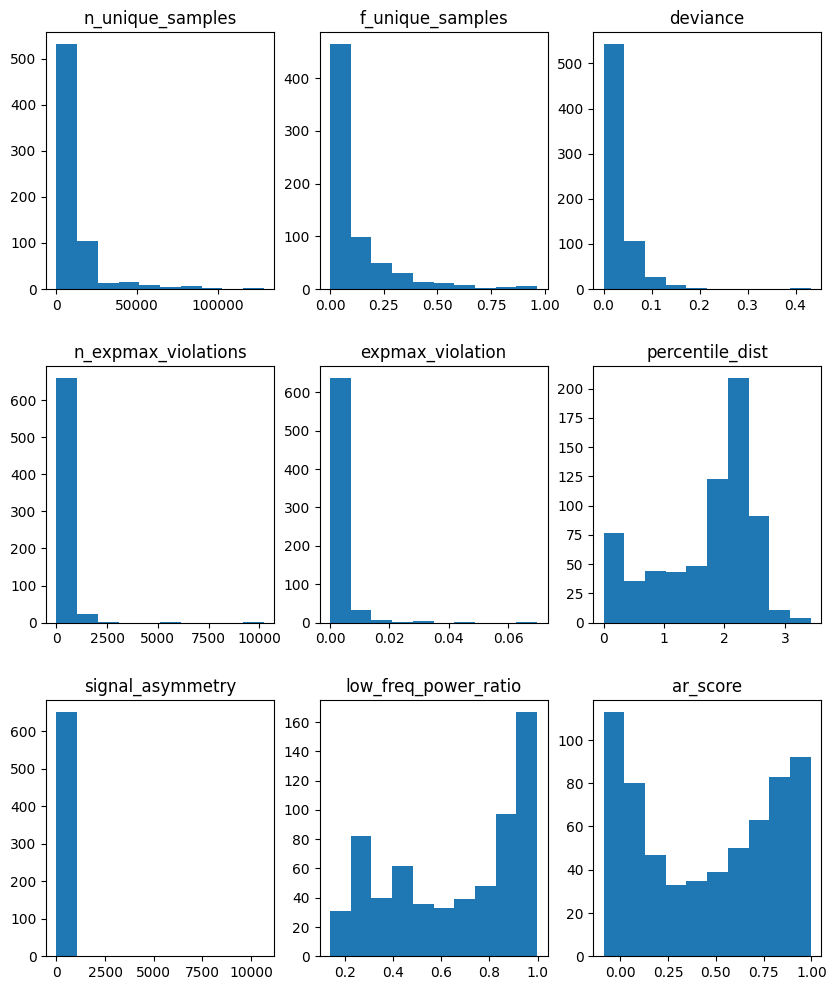

In [7]:
%matplotlib inline

n_metrics = len(raw_metrics + sliding_metrics + processed_metrics)
fig, axs = plt.subplots(int(np.ceil(n_metrics / 3)), 3, figsize=(10, 12))
plt.subplots_adjust(hspace=0.3)
for ax, metric in zip(axs.ravel(), raw_metrics + sliding_metrics + processed_metrics):
    metric_values = df_targets[metric].replace({np.inf:np.nan})
    ax.hist(metric_values.dropna())
    ax.set_title(metric)

In [8]:
colors = {
    'MR-5HT': 'hotpink',
    'DR-5HT': 'mediumorchid',
    'VTA-DA': 'cornflowerblue',
    'SNc-DA': 'mediumslateblue',
    'LC-NE': 'mediumseagreen',
    'NBM-ACh': 'orange',
    'SI-ACh': 'coral',
    'PPT-ACh': 'gold',
}
positions = {
    'MR-5HT': 0,
    'DR-5HT': 1,
    'VTA-DA': 2,
    'SNc-DA': 3,
    'LC-NE': 4,
    'NBM-ACh': 5,
    'SI-ACh': 6,
    'PPT-ACh': 7,
}

def violinplot(
    ax, data, positions=None, log_transform=False, remove_outliers=True, 
    show_outliers=True, outlier_threshold=1.5, colors=None, **violin_kwargs
):
    """
    Draw violin plots on the given axes with options for log transformation and
    outlier detection. Outliers are defined using the IQR method, and are 
    plotted separately as scatter points.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes on which to draw the violins.
    data : list of array-like
        A list where each element is the data (as a 1D array) for one group.
    positions : array-like, optional
        x-axis positions for the violins. If None, defaults to [0, 1, 2, ...].
    log_transform : bool, default False
        If True, apply a natural log transform to each group's data before processing.
        (Your data must be strictly positive, or pre-shifted, when using this.)
    show_outliers : bool, default True
        If True, outliers (as determined by the IQR method) are plotted as separate scatter points.
    outlier_threshold : float, default 1.5
        The multiplier for the IQR to set the outlier boundary.
    violin_kwargs : dict
        Other keyword arguments to pass to ax.violinplot().
    
    Returns
    -------
    violins : matplotlib.collections.PolyCollection
        The object returned by ax.violinplot().
    """
    # Optionally transform each group via log. Ensure the input is a NumPy array.
    if log_transform:
        data = [np.log(x[x > 0]) for x in data]
    else:
        data = [np.array(x) for x in data]
    
    # If positions are not specified, use sequential positions.
    if positions is None:
        positions = np.arange(len(data))

    violin_data = [d for d in data if len(d) >= 10]
    violin_positions = [p for p, d in zip(positions, data) if len(d) >= 10]
    if colors is not None:
        violin_colors = [c for c, d in zip(colors, data) if len(d) >= 10]
    scatter_data = [d for d in data if len(d) < 10]
    scatter_positions = [p for p, d in zip(positions, data) if len(d) < 10]
    if colors is not None:
        scatter_colors = [c for c, d in zip(colors, data) if len(d) < 10] 

    if remove_outliers:
        central_data = []  # Data without outliers, to be plotted in the violins.
        outlier_data = []  # Outlier values to scatter separately.
        # Process each group.
        for vd in violin_data:
            q1, q3 = np.percentile(vd, [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - outlier_threshold * iqr
            upper_bound = q3 + outlier_threshold * iqr
            non_outliers = vd[(vd >= lower_bound) & (vd <= upper_bound)]
            outliers = vd[(vd < lower_bound) | (vd > upper_bound)]
            central_data.append(non_outliers)
            outlier_data.append(outliers)
    else:
        central_data = violin_data

    for p, c, sd in zip(scatter_positions, scatter_colors, scatter_data):
        if len(sd) > 0:
            ax.scatter(np.full(sd.shape, p), sd, s=10, fc='none', ec=c)
        
    
    # Create the violin plot using only the non-outlier data.
    violins = ax.violinplot(
        central_data, 
        violin_positions, 
        showmedians=True, showextrema=False, **violin_kwargs
    )
    if colors is not None:
        for pc, color in zip(violins['bodies'], violin_colors):
            pc.set_facecolor('none')
            pc.set_edgecolor(color)
            pc.set_linewidth(2)
            pc.set_alpha(1)
        violins['cmedians'].set_color(violin_colors)
    
    # Optionally, scatter the outlier points.
    if show_outliers:
        ocolors = ['black' for _ in violin_data] if colors is None else violin_colors
        for xpos, color, outliers in zip(violin_positions, ocolors, outlier_data):
            if len(outliers) > 0:
                ax.scatter(np.full(outliers.shape, xpos), outliers, s=10, fc='none', ec=color)
    
    return violins

In [9]:
slidingmetric_aggfunc = {
    'deviance': np.mean,
    'percentile_dist': np.mean,
    'signal_asymmetry': np.mean,
    'n_expmax_violations': np.sum,
    'expmax_violation': np.mean
}

def _agg_sliding_metric(series, metric=None, agg_func=np.mean, window=300):
    assert metric is not None
    if series[f'_{metric}_values'] is None:
        return np.nan
    t = series[f'_{metric}_times']
    t_mid = t.min() + (t.max() - t.min()) / 2
    i0, i1 = t.searchsorted([t_mid - window, t_mid + window]).clip(0, len(t) - 1)
    # i0, i1 = t.searchsorted([t.min() + buffer, t.max() - buffer])
    evs = series[f'_{metric}_values'][i0:i1]
    return agg_func(evs)

for metric, agg_func in slidingmetric_aggfunc.items():
    df_targets[metric] = df_targets.apply(_agg_sliding_metric, metric=metric, agg_func=agg_func, axis='columns')

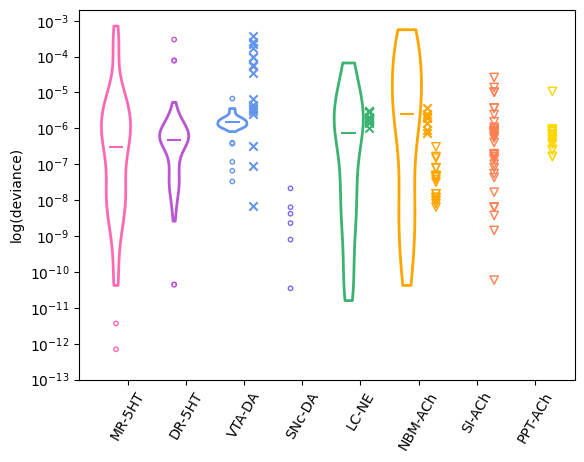

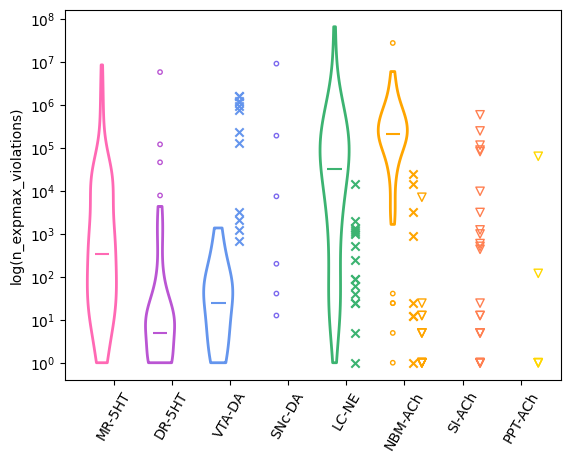

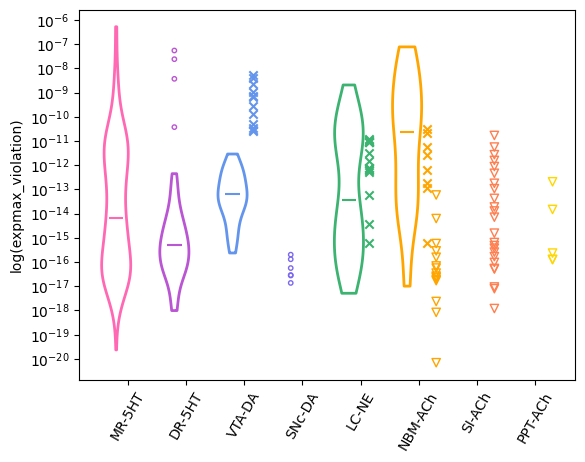

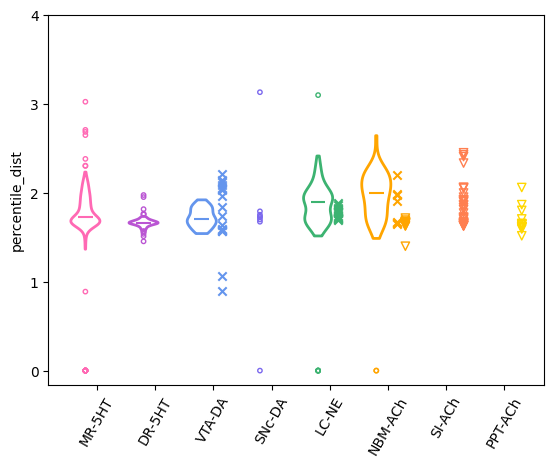

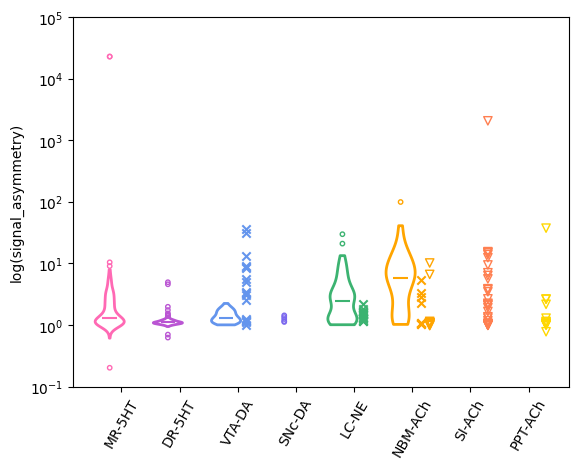

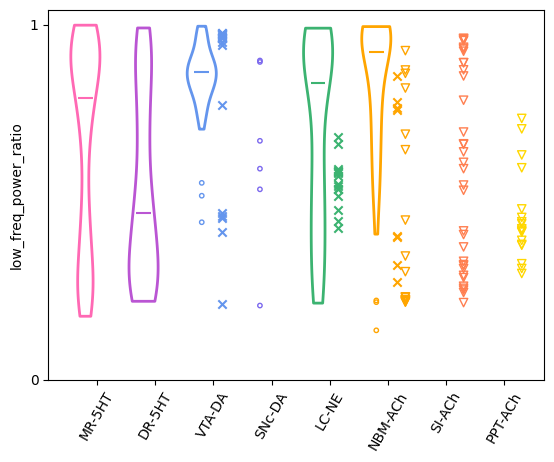

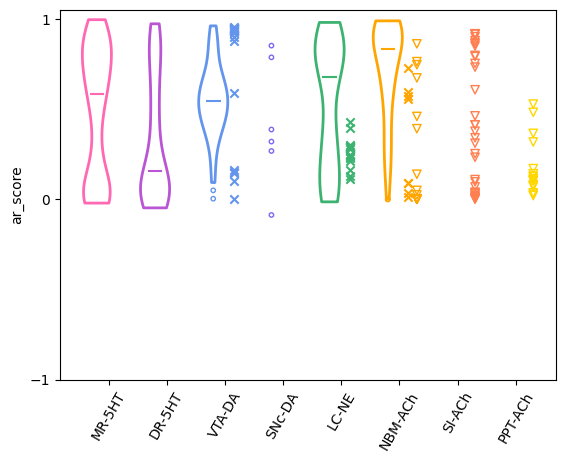

In [10]:
%matplotlib inline

log_transform = {
    'deviance': True,
    'n_expmax_violations': True,
    'expmax_violation': True,
    'percentile_dist': False,
    'signal_asymmetry': True,
    'low_freq_power_ratio': False,
    'ar_score': False
}

target_NMs_old = df_targets[~new_recordings].groupby('target_NM')
target_NMs_new = df_targets[new_recordings].groupby('target_NM')

for metric in sliding_metrics + processed_metrics:
    fig, ax = plt.subplots()
    data = [tnm[metric].replace({np.inf:np.nan}).dropna() for _, tnm in target_NMs_old]
    if log_transform[metric]:
        data = [np.log(x[x > 0]) for x in data]
    else:
        data = [np.array(x) for x in data]
    xpos = np.array(list(positions.values())) - 0.2
    violins = violinplot(ax, data, positions=xpos, colors=colors.values())
    xpos = np.array(list(positions.values()))
    for tnm, group in target_NMs_new:
        group = group.dropna(subset=metric)
        new_data = group[metric].values
        mainenlab = np.array(['ZFM' in s for s in group['subject']])
        if log_transform[metric]:
            mainenlab = mainenlab[new_data > 0]
            new_data = np.log(new_data[new_data > 0])
        xx = np.ones_like(new_data) * (positions[tnm] + 0.2)
        ax.scatter(xx[mainenlab] - 0.05, new_data[mainenlab], color=colors[tnm], marker='x')
        ax.scatter(xx[~mainenlab] + 0.1, new_data[~mainenlab], fc='none', ec=colors[tnm], marker='v')
    ax.set_xticks(list(positions.values()))
    ax.set_xticklabels(positions.keys())
    ax.tick_params(axis='x', rotation=60)
    
    h = np.ceil(max(np.concatenate(data).max(), new_data.max()))
    l = np.floor(min(np.concatenate(data).min(), new_data.min()))
    yticks = np.arange(l, h + 1, 1)
    ax.set_yticks(yticks)
    if log_transform[metric]:
        ax.set_ylabel(f'log({metric})')
        ax.set_yticklabels(['$10^{%d}$' % t for t in yticks])
    else:
        ax.set_ylabel(metric)

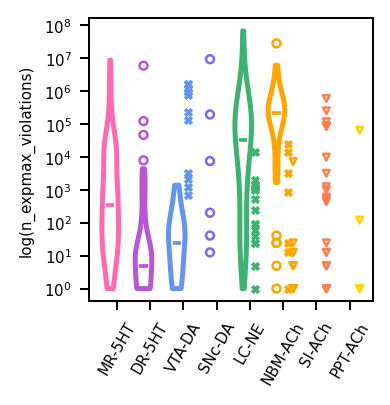

In [195]:
metric = 'n_expmax_violations'

fig, ax = plt.subplots()
data = [tnm[metric].replace({np.inf:np.nan}).dropna() for _, tnm in target_NMs_old]
if log_transform[metric]:
    data = [np.log(x[x > 0]) for x in data]
else:
    data = [np.array(x) for x in data]
xpos = np.array(list(positions.values())) - 0.2
violins = violinplot(ax, data, positions=xpos, colors=colors.values())
xpos = np.array(list(positions.values()))
for tnm, group in target_NMs_new:
    group = group.dropna(subset=metric)
    new_data = group[metric].values
    mainenlab = np.array(['ZFM' in s for s in group['subject']])
    if log_transform[metric]:
        mainenlab = mainenlab[new_data > 0]
        new_data = np.log(new_data[new_data > 0])
    xx = np.ones_like(new_data) * (positions[tnm] + 0.2)
    ax.scatter(xx[mainenlab] - 0.05, new_data[mainenlab], color=colors[tnm], marker='x', s=7)
    ax.scatter(xx[~mainenlab] + 0.1, new_data[~mainenlab], fc='none', ec=colors[tnm], marker='v', s=7)
ax.set_xticks(list(positions.values()))
ax.set_xticklabels(positions.keys())
ax.tick_params(axis='x', rotation=60)

h = np.ceil(max(np.concatenate(data).max(), new_data.max()))
l = np.floor(min(np.concatenate(data).min(), new_data.min()))
yticks = np.arange(l, h + 1, 1)
ax.set_yticks(yticks)
if log_transform[metric]:
    ax.set_ylabel(f'log({metric})')
    ax.set_yticklabels(['$10^{%d}$' % t for t in yticks])
else:
    ax.set_ylabel(metric)
set_plotsize(w=4, ax=ax)
fig.savefig('qc/figures/n_expmax_violins.svg')

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/cro

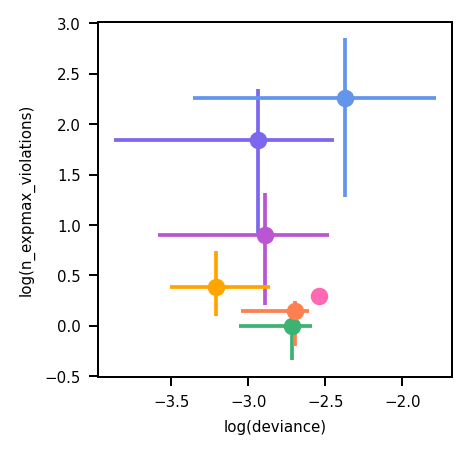

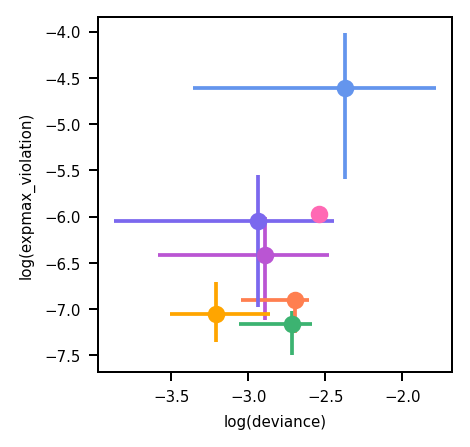

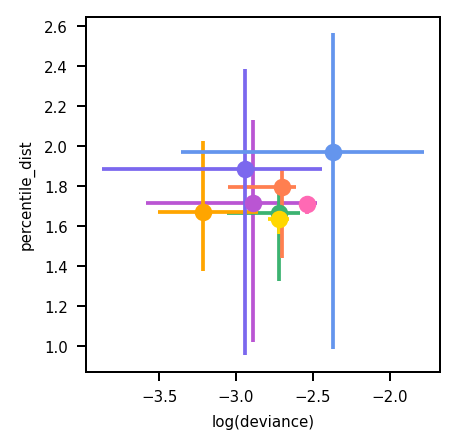

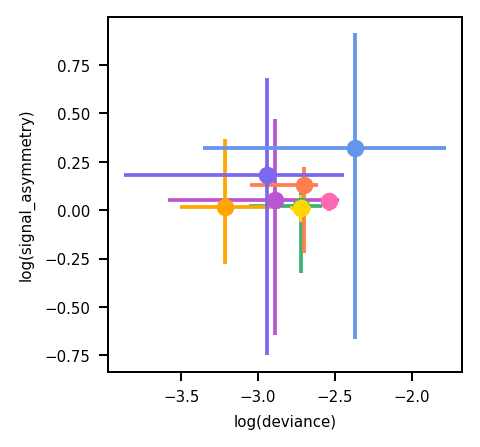

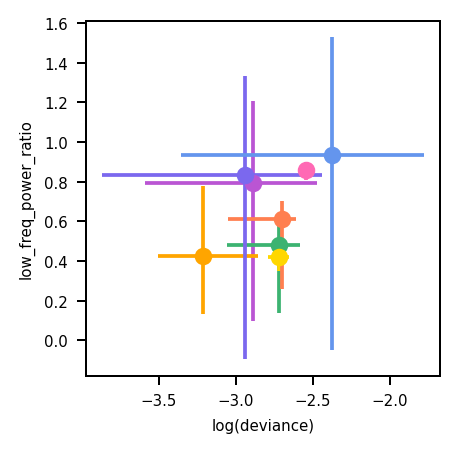

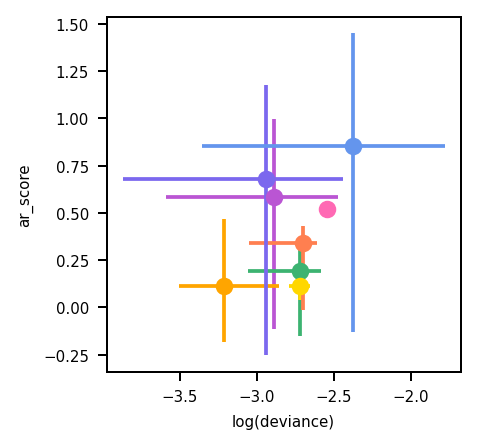

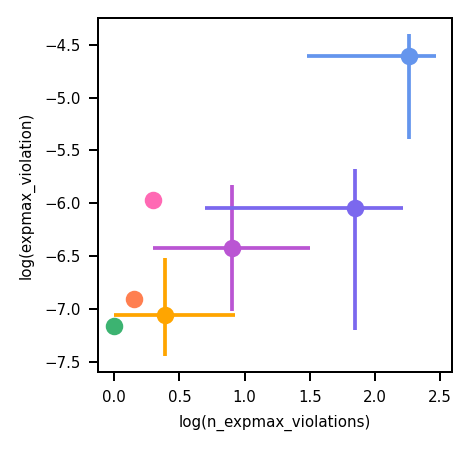

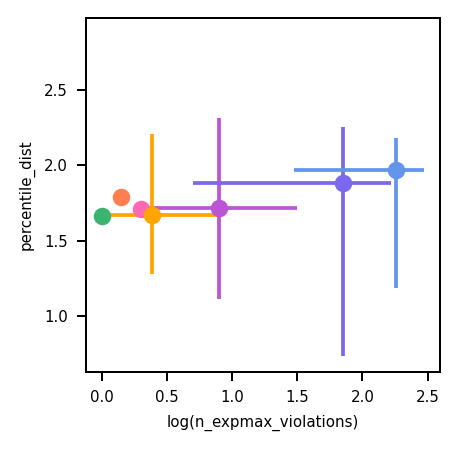

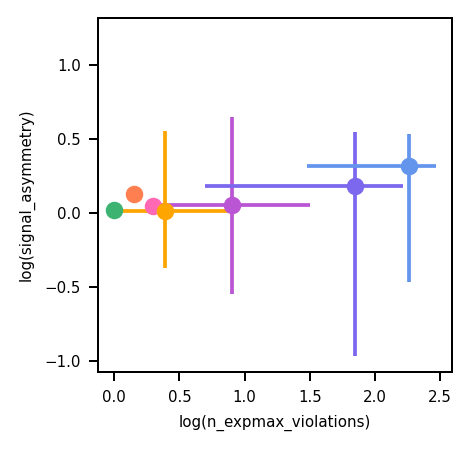

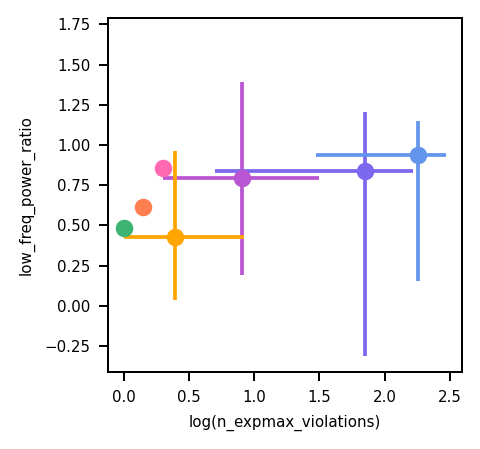

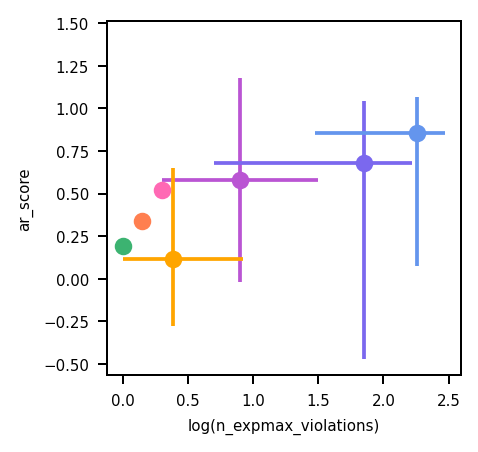

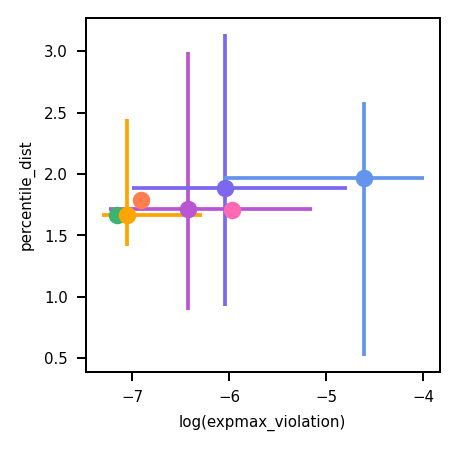

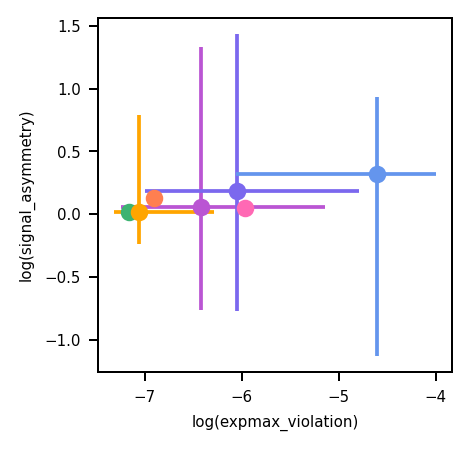

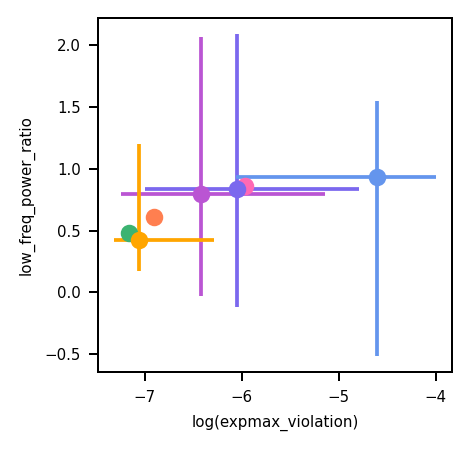

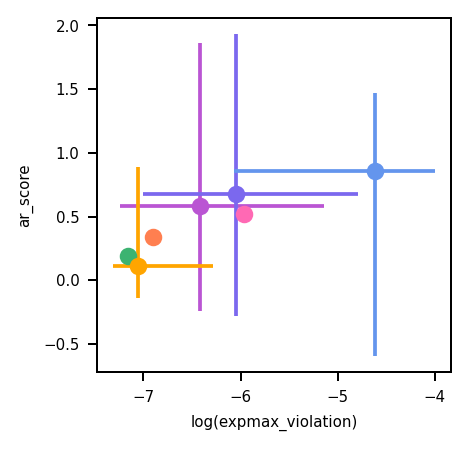

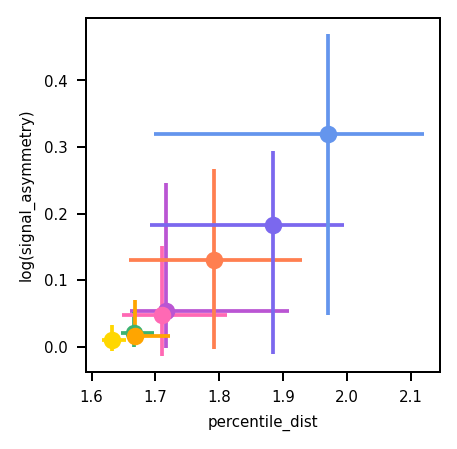

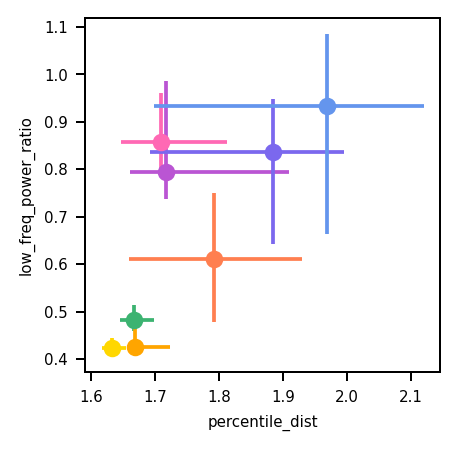

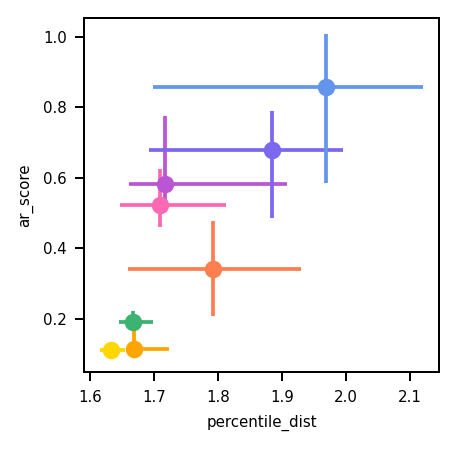

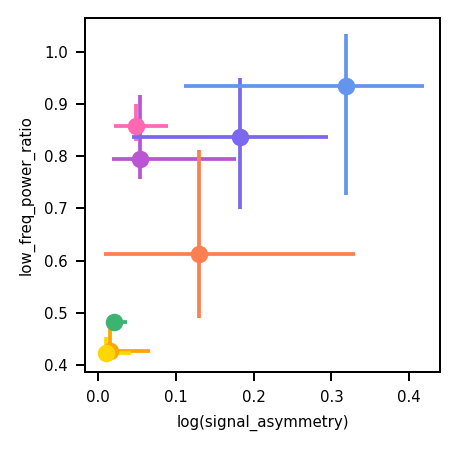

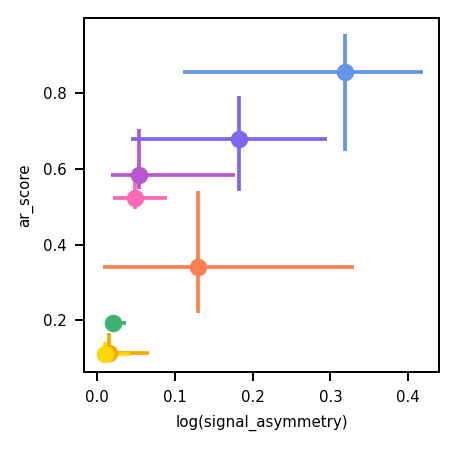

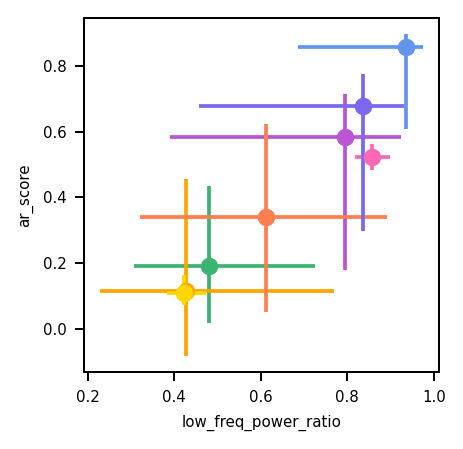

In [186]:
m = sliding_metrics + processed_metrics

log_transform = {
    'deviance': True,
    'n_expmax_violations': True,
    'expmax_violation': True,
    'percentile_dist': False,
    'signal_asymmetry': True,
    'low_freq_power_ratio': False,
    'ar_score': False
}

for i in range(len(m)):
    for j in range(len(m)):
        if i >= j:
            continue

        fig, ax = plt.subplots()
        for target_NM, group in df_targets.groupby('target_NM'):
            
            mi_values = np.log10(group[m[i]]) if log_transform[m[i]] else group[m[i]]
            x_neg, x, x_pos = mi_values.dropna().quantile([.25, .5, .75])
            x_neg = x - x_neg
            x_pos = x_pos - x
            
            mj_values = np.log10(group[m[j]]) if log_transform[m[j]] else group[m[j]]
            y_neg, y, y_pos = mj_values.dropna().quantile([.25, .5, .75])
            y_neg = y - y_neg
            y_pos = y_pos - y
            
            ax.errorbar(x, y, marker='o', xerr=np.array([[x_neg], [x_pos]]), yerr=np.array([[x_neg], [x_pos]]), color=colors[target_NM])
            if log_transform[m[i]]:
                ax.set_xlabel(f'log({m[i]})')
            else:
                ax.set_xlabel(m[i])
            if log_transform[m[j]]:
                ax.set_ylabel(f'log({m[j]})')
            else:
                ax.set_ylabel(m[j])
        
        set_plotsize(w=5, ax=ax)

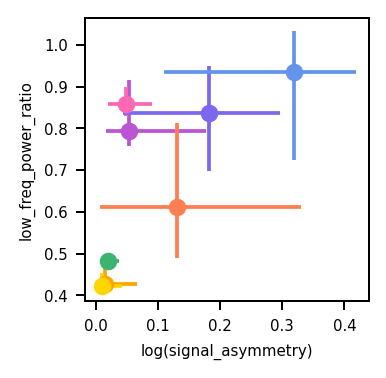

In [190]:
m0 = 'signal_asymmetry'
m1 = 'low_freq_power_ratio'

fig, ax = plt.subplots()
for target_NM, group in df_targets.groupby('target_NM'):
    
    m0_values = np.log10(group[m0]) if log_transform[m0] else group[m0]
    x_neg, x, x_pos = m0_values.dropna().quantile([.25, .5, .75])
    x_neg = x - x_neg
    x_pos = x_pos - x
    
    m1_values = np.log10(group[m1]) if log_transform[m1] else group[m1]
    y_neg, y, y_pos = m1_values.dropna().quantile([.25, .5, .75])
    y_neg = y - y_neg
    y_pos = y_pos - y
    
    ax.errorbar(x, y, marker='o', xerr=np.array([[x_neg], [x_pos]]), yerr=np.array([[x_neg], [x_pos]]), color=colors[target_NM])
    if log_transform[m0]:
        ax.set_xlabel(f'log({m0})')
    else:
        ax.set_xlabel(m0)
    if log_transform[m1]:
        ax.set_ylabel(f'log({m1})')
    else:
        ax.set_ylabel(m1)

set_plotsize(w=4, ax=ax)
fig.savefig('qc/figures/2dscatter.svg')

#### Fix dt_violations

In [46]:
def find_early_samples(A: pd.DataFrame | pd.Series, dt_tol: float = 0.001) -> np.ndarray:
    dt = np.median(np.diff(A.index))
    return dt - A.index.diff() > dt_tol


def _fill_missing_channel_names(A: np.ndarray) -> np.ndarray:
    missing_inds = np.where(A == '')[0]
    name_alternator = {'GCaMP': 'Isosbestic', 'Isosbestic': 'GCaMP', '': ''}
    for i in missing_inds:
        if i == 0:
            A[i] = name_alternator[A[i + 1]]
        else:
            A[i] = name_alternator[A[i - 1]]
    return A


def find_repeated_samples(
    A: pd.DataFrame,
    dt_tol: float = 0.001,
) -> int:
    if any(A['name'] == ''):
        A['name'] = _fill_missing_channel_names(A['name'].values)
    else:
        A
    repeated_sample_mask = A['name'].iloc[1:].values == A['name'].iloc[:-1].values
    repeated_samples = A.iloc[1:][repeated_sample_mask]
    dt = np.median(np.diff(A.index))
    early_samples = A[find_early_samples(A, dt_tol=dt_tol)]
    if not all([idx in early_samples.index for idx in repeated_samples.index]):
        print("WARNING: repeated samples found without early sampling")
    return repeated_sample_mask

def fix_repeated_sampling(
    A: pd.DataFrame,
    dt_tol: float = 0.001,
    w_size: int = 10,
    roi: str | None = None
) -> int:
    ## TODO: avoid this by explicitly handling multiple channels
    assert roi is not None
    # Drop first samples if channel labels are missing
    A.loc[A['name'].replace({'':np.nan}).first_valid_index():]
    # Fix remaining missing channel labels
    if any(A['name'] == ''):
        A['name'] = _fill_missing_channel_names(A['name'].values)
    repeated_sample_mask = find_repeated_samples(A, dt_tol=dt_tol)
    name_alternator = {'GCaMP':'Isosbestic', 'Isosbestic': 'GCaMP'}
    for i in (np.where(repeated_sample_mask)[0] + 1):
        name = A.iloc[i]['name']
        value = A.iloc[i][roi]
        i0, i1 = A.index[i - w_size], A.index[i]
        same = A.loc[i0:i1].query('name == @name')[roi].mean()
        other_name = name_alternator[name]
        other = A.loc[i0:i1].query('name == @other_name')[roi].mean()
        assert np.abs(value - same) > np.abs(value - other)
        A.loc[A.index[i]:, 'name'] = [name_alternator[name] for name in A.loc[A.index[i]:, 'name']]
    return A

In [197]:
session = df_targets[(df_targets['dt_violations'] > 1) & (df_targets['interleaved_acquisition'] == False)].iloc[8]
# eid = 'c5cdd496-7400-4c0f-b326-55016bce4fcf'  # cluster of spikes
# eid = 'cab30b9f-fa1d-4f39-86f2-58e9265bd9f4'  # long-term channel swap
# session = df_targets.query('eid == @eid').iloc[0]
print(session['eid'], session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

cab30b9f-fa1d-4f39-86f2-58e9265bd9f4 training


interleaved_acquisition       False
n_unique_samples              16006
f_unique_samples           0.391201
dt_violations                   279
deviance                    0.02478
n_spikes_dy                      15
expmax_violation                0.0
percentile_dist            0.516677
signal_asymmetry           0.155335
ar_score                   0.050623
Name: 194, dtype: object

In [209]:
try:
    photometry = load_photometry_data(session, one_remote, extracted=True)
except:
    photometry = load_photometry_data(session, one_local, extracted=False)
photometry

,Region4G,name
times,,
2988.692832,0.009247,GCaMP
2988.726176,0.022044,Isosbestic
2988.759520,0.009321,GCaMP
2988.792832,0.020027,Isosbestic
2988.826176,0.009366,GCaMP
...,...,...
5734.204288,0.017996,GCaMP
5734.237600,0.009098,Isosbestic
5734.270944,0.017975,GCaMP


In [210]:
%matplotlib tk

fig, ax = plt.subplots()
ax.plot(photometry.query('name == "GCaMP"')[session['ROI'][0]], marker='o')
ax.plot(photometry.query('name == "Isosbestic"')[session['ROI'][0]], marker='o')

In [211]:
# Check for early sampling
early_samples = find_early_samples(photometry)
early_samples.sum()

np.int64(5)

In [201]:
# Remove first samples if channel names are blank
photometry = photometry.loc[photometry['name'].replace({'':np.nan}).first_valid_index():]
_fill_missing_channel_names(photometry['name'].values)

array(['GCaMP', 'Isosbestic', 'GCaMP', ..., 'GCaMP', 'Isosbestic',
       'GCaMP'], dtype=object)

In [202]:
repeated_sample_mask = find_repeated_samples(photometry)
repeated_sample_mask.sum()

np.int64(3)

             Region4G        name
times                            
3235.851360  0.020202  Isosbestic
3235.884672  0.010417       GCaMP
3235.909056  0.020191       GCaMP
3235.918016  0.010425  Isosbestic
             Region4G        name
times                            
3523.775264  0.010109  Isosbestic
3523.808576  0.019644       GCaMP
3523.812768  0.010013       GCaMP
3523.812832  0.019665       GCaMP
             Region4G        name
times                            
3523.808576  0.019644       GCaMP
3523.812768  0.010013       GCaMP
3523.812832  0.019665       GCaMP
3523.841920  0.009957  Isosbestic


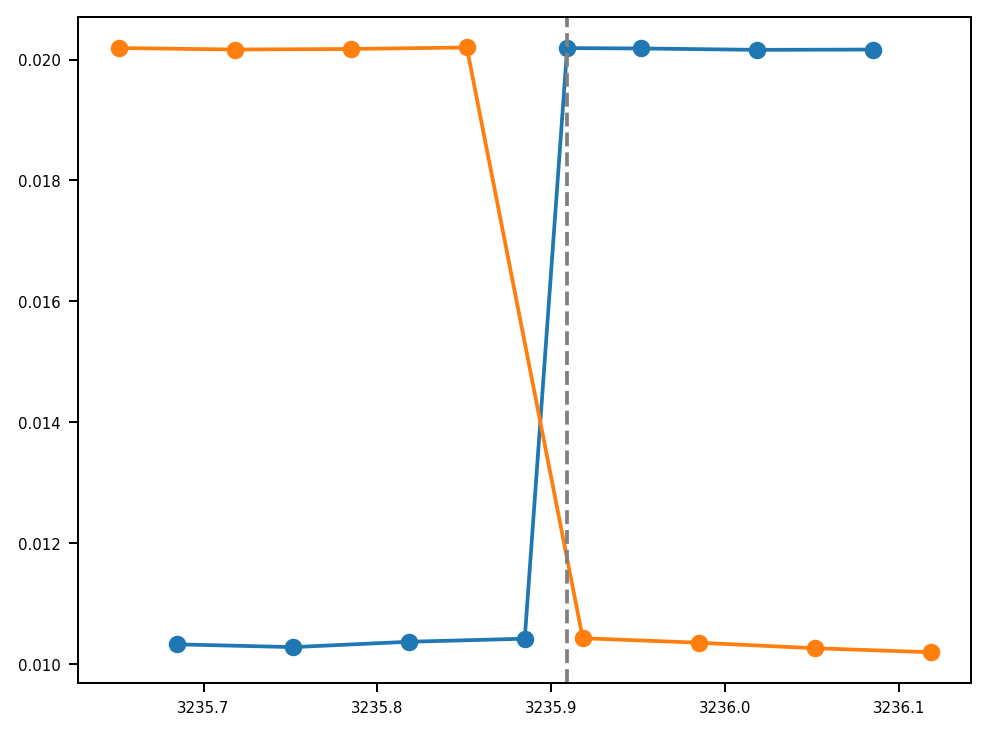

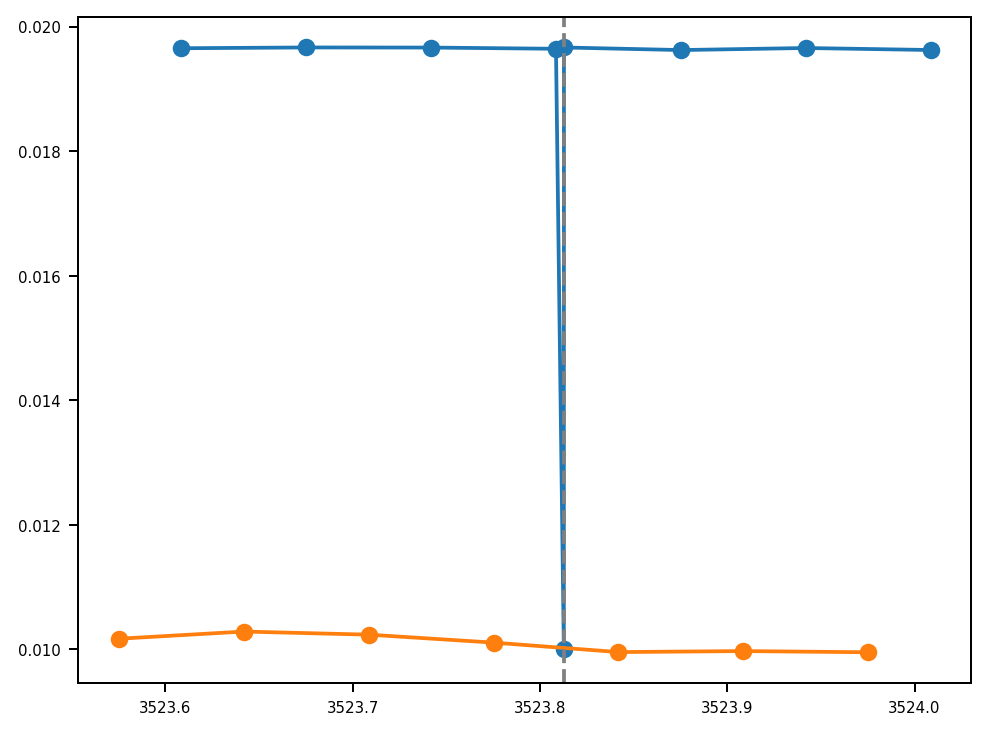

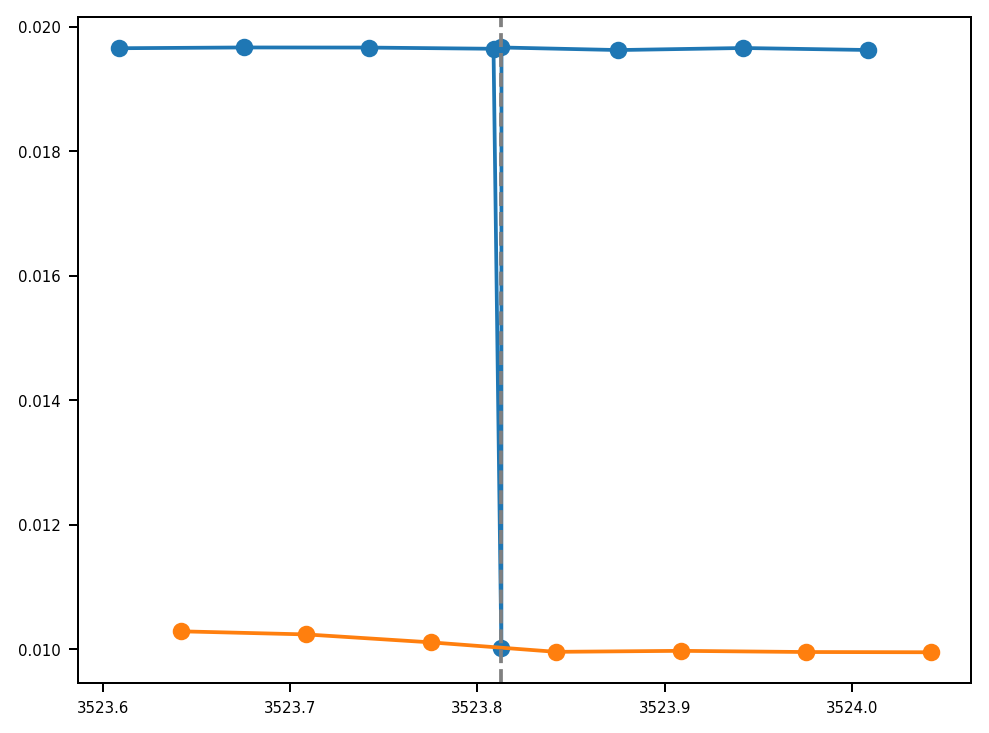

In [203]:
%matplotlib inline

for i in np.where(repeated_sample_mask)[0] + 1:
    print(photometry.iloc[(i - 2):(i + 2)])
    fig, ax = plt.subplots()
    ax.plot(photometry.iloc[(i - 8):(i + 8)].query('name == "GCaMP"')[session['ROI'][0]], marker='o')
    ax.plot(photometry.iloc[(i - 8):(i + 8)].query('name == "Isosbestic"')[session['ROI'][0]], marker='o')
    ax.axvline(photometry.index[i], ls='--', color='gray')

In [204]:
photometry_fixed = fix_repeated_sampling(photometry, roi=session['ROI'][0])

             Region4G        name
times                            
3235.851360  0.020202  Isosbestic
3235.884672  0.010417       GCaMP
3235.909056  0.020191  Isosbestic
3235.918016  0.010425       GCaMP
             Region4G        name
times                            
3523.775264  0.010109       GCaMP
3523.808576  0.019644  Isosbestic
3523.812768  0.010013       GCaMP
3523.812832  0.019665  Isosbestic
             Region4G        name
times                            
3523.808576  0.019644  Isosbestic
3523.812768  0.010013       GCaMP
3523.812832  0.019665  Isosbestic
3523.841920  0.009957       GCaMP


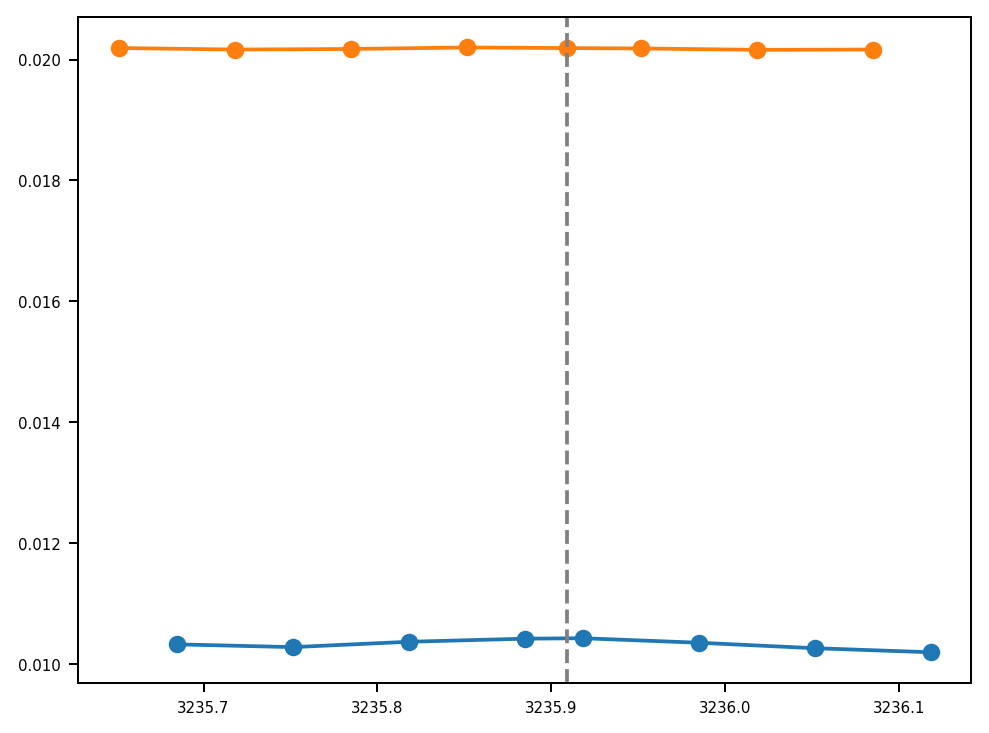

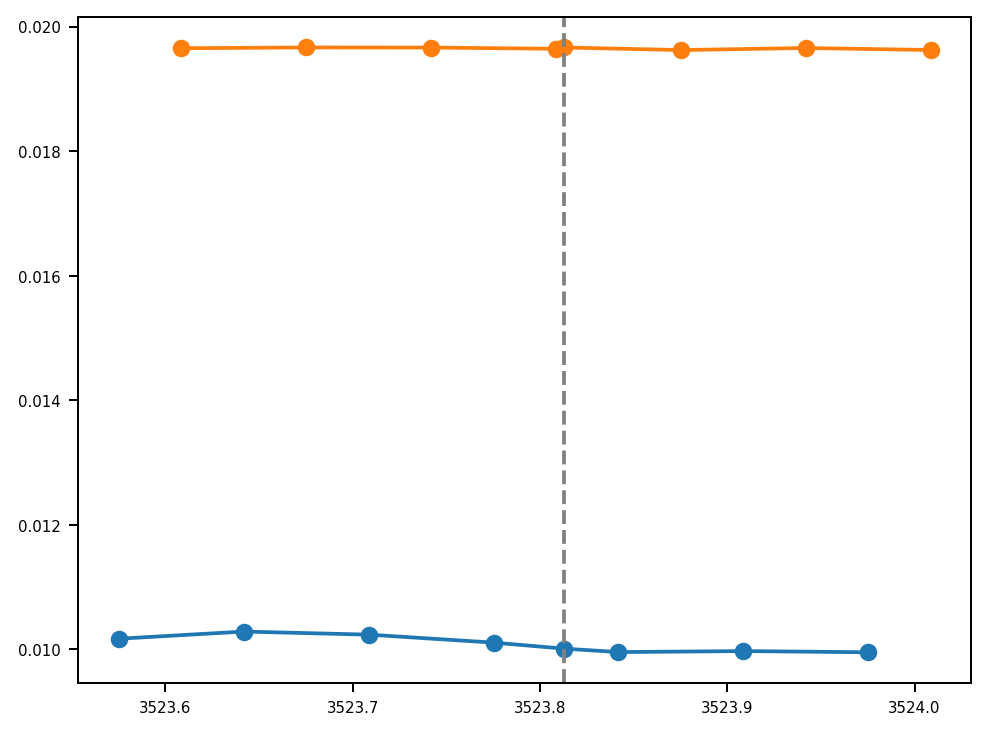

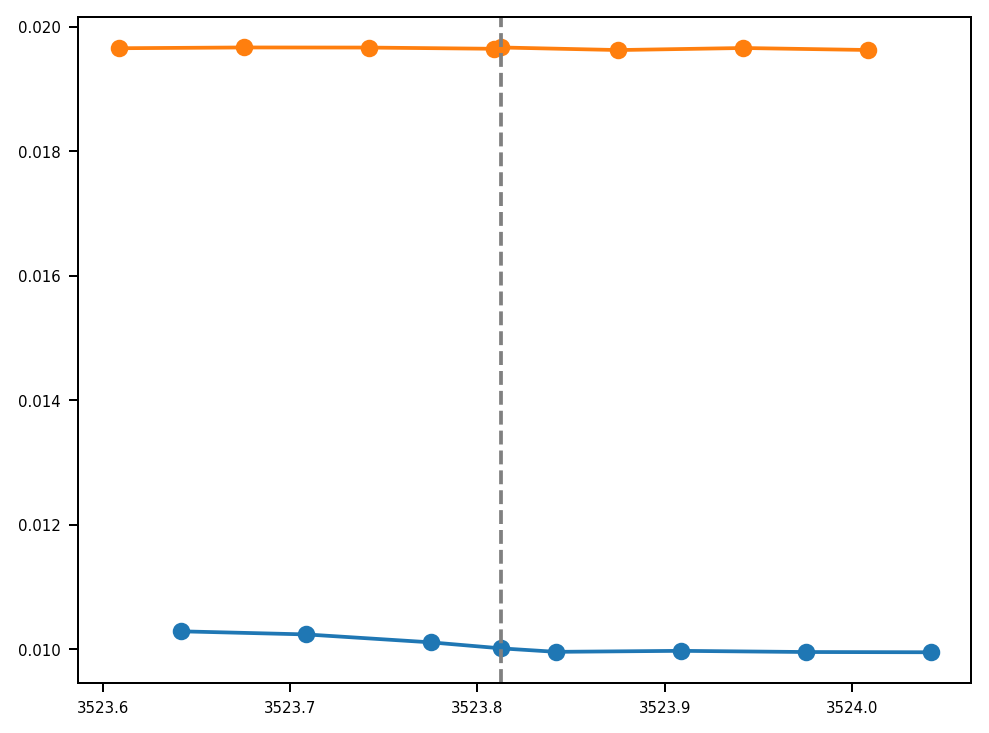

In [205]:
%matplotlib inline

for i in np.where(repeated_sample_mask)[0] + 1:
    print(photometry_fixed.iloc[(i - 2):(i + 2)])
    fig, ax = plt.subplots()
    ax.plot(photometry_fixed.iloc[(i - 8):(i + 8)].query('name == "GCaMP"')[session['ROI'][0]], marker='o')
    ax.plot(photometry_fixed.iloc[(i - 8):(i + 8)].query('name == "Isosbestic"')[session['ROI'][0]], marker='o')
    ax.axvline(photometry_fixed.index[i], ls='--', color='gray')

In [212]:
gcamp = photometry.query('name == "GCaMP"')
iso = photometry.query('name == "Isosbestic"')

In [214]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 3200, 3600

i0, i1 = iso.index.values.searchsorted([t0, t1])
ax.plot(iso.iloc[i0:i1][session['ROI'][0]], color='gray', label='Isosbestic')
i0, i1 = gcamp.index.values.searchsorted([t0, t1])
ax.plot(gcamp.iloc[i0:i1][session['ROI'][0]], color=colors[session['target_NM']], label='GCaMP')

ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
ax.set_ylabel('Signal (a.u.)')
# ax.legend(loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title(f"{session['target_NM']}", fontsize=8)
set_plotsize(w=5, h=2, ax=ax)
fig.savefig('qc/figures/spikes_signal.svg')

In [147]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 1872.6, 1873.2

i0, i1 = iso.index.values.searchsorted([t0, t1])
ax.plot(iso.iloc[i0:i1][session['ROI'][0]], marker='o', markersize=2, lw=1, color='gray', label='Isosbestic')
i0, i1 = gcamp.index.values.searchsorted([t0, t1])
ax.plot(gcamp.iloc[i0:i1][session['ROI'][0]], marker='o', markersize=2, lw=1, color=colors[session['target_NM']], label='GCaMP')

ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
ax.set_ylabel('Signal (a.u.)')
set_plotsize(w=2.5, h=2, ax=ax)
fig.savefig('qc/figures/spikes_zoom.svg')

In [215]:
photometry_fixed = fix_repeated_sampling(photometry, roi=session['ROI'][0])
gcamp = photometry_fixed.query('name == "GCaMP"')
iso = photometry_fixed.query('name == "Isosbestic"')

In [150]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 1872.6, 1873.2

i0, i1 = iso.index.values.searchsorted([t0, t1])
ax.plot(iso.iloc[i0:i1][session['ROI'][0]], marker='o', markersize=2, lw=1, color='gray', label='Isosbestic')
i0, i1 = gcamp.index.values.searchsorted([t0, t1])
ax.plot(gcamp.iloc[i0:i1][session['ROI'][0]], marker='o', markersize=2, lw=1, color=colors[session['target_NM']], label='GCaMP')

ax.set_xlabel('Time (s)')
ax.set_yticklabels([])
set_plotsize(w=2.5, h=2, ax=ax)
fig.savefig('qc/figures/spikes_fixed.svg')

In [23]:
gcamp = photometry.query('name == "GCaMP"')
iso = photometry.query('name == "Isosbestic"')
F = gcamp[session['ROI']]
F_iso = iso[session['ROI']]

In [24]:
%matplotlib tk
plt.plot(F, marker='o', color='black')
plt.plot(F_iso, marker='o', color='gray')

In [267]:
session = df_targets[df_targets['n_unique_samples'] > 1000].iloc[113]
# eid = 'e898dfa4-f21d-42d6-81d4-9bf4f3e577bf'  # good low n example
# eid = 'a44f72af-755f-4d58-b9bb-c5b345bcd788'  # good low n, high amp example
# session = df_targets.query('eid == @eid').iloc[0]
print(session['target_NM'], session['eid'], session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

VTA-DA f0a4d6d8-724d-4c7c-af7f-78b8ef0df7b3 training


interleaved_acquisition        True
n_unique_samples              14759
f_unique_samples           0.088953
dt_violations                   507
deviance                   0.043978
n_spikes_dy                     695
expmax_violation           0.000357
percentile_dist            1.144983
signal_asymmetry           0.352556
ar_score                   0.847031
Name: 241, dtype: object

In [268]:
try:
    photometry = load_photometry_data(session, one_remote, extracted=True)
except:
    photometry = load_photometry_data(session, one_local, extracted=False)
photometry

,Region4G,name
times,,
971.240192,0.006644,GCaMP
971.256864,0.009921,Isosbestic
971.273536,0.006645,GCaMP
971.290176,0.011769,Isosbestic
971.306848,0.006595,GCaMP
...,...,...
6530.046304,0.003949,GCaMP
6530.062976,0.006259,Isosbestic
6530.079648,0.003945,GCaMP


In [269]:
%matplotlib tk

fig, ax = plt.subplots()
ax.plot(photometry.query('name == "GCaMP"')[session['ROI'][0]])

In [270]:
gcamp = photometry.query('name == "GCaMP"')

In [271]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 3560, 3570

i0, i1 = gcamp.index.values.searchsorted([t0, t1])
ax.plot(gcamp.iloc[i0:i1][session['ROI'][0]], color=colors[session['target_NM']], label='GCaMP')

ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-3, 3])
ax.set_ylabel('Signal (a.u.)')
# ax.legend(loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title(f"{session['target_NM']}, n_unique_samples={session['n_unique_samples']}")
set_plotsize(w=5, h=2, ax=ax)
fig.savefig('qc/figures/nunique_high.svg')

In [11]:
def psth(F, ts, t0=0.1, t1=1):
    tpts = F.index.values
    ts = ts[(ts - t0 > tpts.min()) & (ts + t1 < tpts.max())]
    inds = tpts.searchsorted(ts)
    dt = np.median(np.diff(tpts))
    i0s = inds - int(t0 // dt)
    i1s = inds + int(t1 // dt)
    responses = np.stack([F.values[i0:i1] for i0, i1 in zip(i0s, i1s)])
    tpts_resp = np.linspace(-1 * t0, t1, responses.shape[1])
    responses = (responses.T - responses[:, tpts_resp.searchsorted(0)]).T
    return responses, tpts_resp

def set_plotsize(w, h=None, ax=None):
    """
    Set the size of a matplotlib axes object in cm.

    Parameters
    ----------
    w, h : float
        Desired width and height of plot, if height is None, the axis will be
        square.

    ax : matplotlib.axes
        Axes to resize, if None the output of plt.gca() will be re-sized.

    Notes
    -----
    - Use after subplots_adjust (if adjustment is needed)
    - Matplotlib axis size is determined by the figure size and the subplot
      margins (r, l; given as a fraction of the figure size), i.e.
      w_ax = w_fig * (r - l)
    """
    if h is None: # assume square
        h = w
    w /= 2.54 # convert cm to inches
    h /= 2.54
    if not ax: # get current axes
        ax = plt.gca()
    # get margins
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    # set fig dimensions to produce desired ax dimensions
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

LABELFONTSIZE = 6
plt.rcParams['figure.dpi'] = 180
plt.rcParams['axes.labelsize'] = LABELFONTSIZE
plt.rcParams['xtick.labelsize'] = LABELFONTSIZE 
plt.rcParams['ytick.labelsize'] = LABELFONTSIZE 
plt.rcParams['legend.fontsize'] = LABELFONTSIZE 
plt.rcParams['axes.titlesize'] = LABELFONTSIZE 

### Pair-wise metric evaluation

In [12]:
# Remove obviously bad recordings
df = df_targets[df_targets['n_unique_samples'] > 100].copy()

In [16]:
from matplotlib.patches import Rectangle

In [74]:
for metric in raw_metrics + sliding_metrics + processed_metrics:
    df[f'log_{metric}'] = np.log10(df[metric])

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
metrics = ['log_deviance', 'ar_score']
df[metrics] = df[metrics].replace({np.inf:np.nan, -np.inf:np.nan})
df = df.dropna(subset=metrics).dropna()

D, x_bins, y_bins = np.histogram2d(df[metrics[0]], df[metrics[1]], bins=16)

w = 3
ix0, iy0 = 8, 13
ix1, iy1 = ix0 + w, iy0 + w

/tmp/ipykernel_141462/1759412362.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.matshow(np.log10(D.T), cmap='YlOrBr')


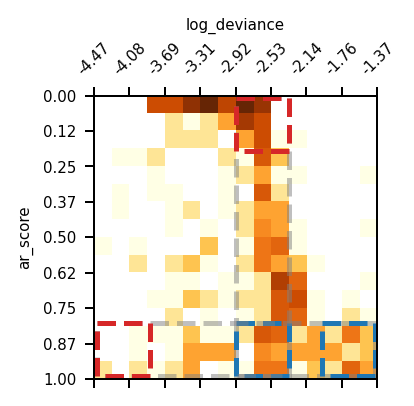

In [124]:
%matplotlib inline

fig, ax = plt.subplots()
ax.matshow(np.log10(D.T), cmap='YlOrBr')

ax.add_patch(
    Rectangle((ix0 - 0.5, -0.35), (ix1 - ix0), len(y_bins) - 1.3, fc='none', ec='gray', alpha=0.5, ls='--', lw=2)
)
ax.add_patch(
    Rectangle((ix0 - 0.5, -0.35), (ix1 - ix0), 3, fc='none', ec='tab:red', ls='--', lw=2)
)
ax.add_patch(
    Rectangle((ix0 - 0.5, 12.35), (ix1 - ix0), 3, fc='none', ec='tab:blue', ls='--', lw=2)
)


ax.add_patch(
    Rectangle((-0.35, iy0 - 0.65), len(x_bins) - 1.3, (iy1 - iy0), fc='none', ec='gray', alpha=0.5, ls='--', lw=2)
)
ax.add_patch(
    Rectangle((-0.35, iy0 - 0.65), 3, (iy1 - iy0), fc='none', ec='tab:red', ls='--', lw=2)
)
ax.add_patch(
    Rectangle((12.35, iy0 - 0.65), 3, (iy1 - iy0), fc='none', ec='tab:blue', ls='--', lw=2)
)

ax.set_xticks(np.arange(len(x_bins))[::2] - 0.5)
ax.set_xticklabels([f'{x:.2f}' for x in x_bins[::2]])
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel(metrics[0])
ax.xaxis.set_label_position('top')
ax.set_yticks(np.arange(len(y_bins))[::2] - 0.5)
ax.set_yticklabels([f'{y:.2f}' for y in y_bins[::2]])
ax.set_ylabel(metrics[1])
set_plotsize(w=4, ax=ax)

fig.savefig('qc/figures/metrics_joint.svg')

In [18]:
def sample_from_bin_2d(df, ranges):
    (m0, m0_range), (m1, m1_range) = ranges.items()
    m0_mask = (df[m0] >= m0_range[0]) & (df[m0] <= m0_range[1])
    m1_mask = (df[m1] >= m1_range[0]) & (df[m1] <= m1_range[1])
    return df[m0_mask & m1_mask]

In [59]:
ranges = {
    metrics[0]: (x_bins[13], x_bins[16]),
    metrics[1]: (y_bins[iy0], y_bins[iy1])
}
df_samples = sample_from_bin_2d(df, ranges)
len(df_samples)

33

In [60]:
session_idx = np.random.choice(df_samples.index)
session = df_samples.loc[session_idx]
# eid = 'a7366bb4-8e5d-44fc-97f8-af129659b9c6'  # bad ar_score
# eid = '87a8de43-8576-450c-be35-4fccaa4e1d14'  # good ar_score
# eid = 'aa211f0c-94df-4f8a-9775-b8fcec3f5138'  # bad deviance
# session = df_samples[df_samples['eid'] == eid].iloc[0]
print(session['target_NM'], session['eid'], session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

VTA-DA db14d055-31c5-4a7e-a09a-3ab89aafa473 biased


n_early_samples                6
n_repeated_samples             3
n_unique_samples           14285
f_unique_samples         0.12176
deviance                0.018508
n_expmax_violations        241.0
expmax_violation        0.000275
percentile_dist         1.866149
signal_asymmetry        1.721961
low_freq_power_ratio    0.916214
ar_score                0.821469
Name: 282, dtype: object

In [61]:
try:
    photometry = load_photometry_data(session, one_remote, extracted=True)
except:
    photometry = load_photometry_data(session, one_local, extracted=False)

gcamp = photometry.query('name == "GCaMP"')
F = gcamp[session['ROI']]

In [65]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 2550, 2610
i0, i1 = F.index.values.searchsorted([t0, t1])

ax.plot(F.iloc[i0:i1], color=colors[session['target_NM']], label='GCaMP raw')
# ax.plot(F, color=colors[session['target_NM']], label='GCaMP raw')
ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
ax.set_ylabel('Signal (a.u.)')
ax.set_title(f"{session['target_NM']} - GCaMP raw")
set_plotsize(w=5, h=2, ax=ax)
fig.savefig('qc/figures/deviance_good_signal.svg')

In [129]:
def plot_joint_distributions(df, metrics=None, transform=True, bins=30, figsize=(5, 5)):
    """
    Plots joint distributions for each pair of metrics in the upper triangle of a grid.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the metrics as columns.
    metrics : list
        List of column names in `df` representing the metrics.
    figsize : tuple, optional
        Size of the figure. Default is (10, 10).
    bins : int, optional
        Number of bins for the histograms. Default is 30.

    Returns
    -------
    None
    """
    if metrics is None:
        metrics = df.columns
    n_metrics = len(metrics)

    X = df[metrics].dropna().values
    corr = df[metrics].dropna().corr(method='spearman')
    if transform:
        X = quantile_transform(X, output_distribution='normal', n_quantiles=500)
    
    fig, axs = plt.subplots(n_metrics, n_metrics, figsize=figsize)
    
    for i in range(n_metrics):
        for j in range(n_metrics):
            ax = axs[i, j]
            
            if i < j:  # Upper triangle: plot joint distributions
                x = X[:, j]
                y = X[:, i]
                ax.hist2d(x, y, bins=bins, cmap='YlOrBr', density=True, norm='log')
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                ax.set_xlabel(metrics[j] if i == n_metrics - 1 else "")
                ax.set_ylabel(metrics[i] if j == 0 else "")
                ax.text(0.01, 0.8, r'$\rho$' + f'={corr.iloc[i, j]:.2f}', fontsize=6, transform=ax.transAxes)
            elif i == j:  # Diagonal: plot histograms
                data = X[:, i]
                ax.hist(data, bins=bins, color='gray', alpha=0.7)
                ax.set_xticks([])
                ax.set_yticks([])
                lbl = ax.set_ylabel(metrics[i], rotation=25)
                lbl.set_horizontalalignment('right')
                lbl.set_verticalalignment('center')
            else:  # Lower triangle: turn off axes
                ax.axis("off")
    return fig, X

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwar

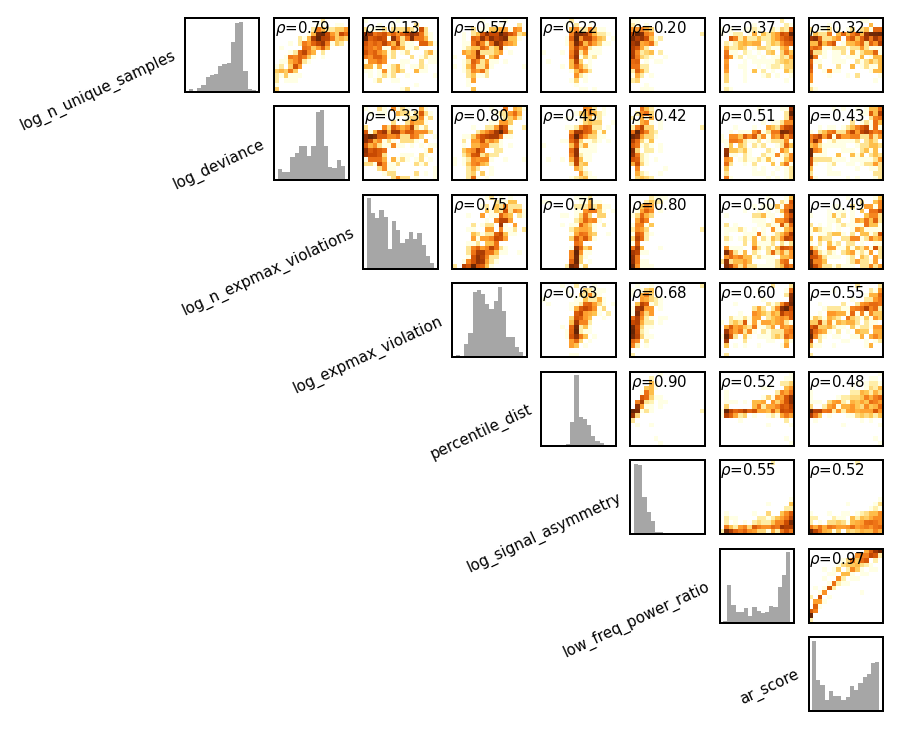

In [131]:
%matplotlib inline

comp_metrics = [
    'log_n_unique_samples',
    'log_deviance',
    'log_n_expmax_violations',
    'log_expmax_violation',
    'percentile_dist',
    'log_signal_asymmetry',
    'low_freq_power_ratio',
    'ar_score'
]
df_comp = df_targets.copy()
for metric in raw_metrics + sliding_metrics + processed_metrics:
    df_comp[f'log_{metric}'] = np.log10(df_comp[metric])
df_comp[comp_metrics] = df_comp[comp_metrics].replace({np.inf:np.nan, -np.inf:np.nan})

fig, X = plot_joint_distributions(df_comp[comp_metrics], transform=False, bins=16)
fig.savefig('qc/figures/corrmat.svg')

In [151]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X = df_comp[comp_metrics].dropna().values
scaler = MinMaxScaler()
pca = PCA(n_components=2)
Xpc = pca.fit_transform(scaler.fit_transform(X))
sum(pca.explained_variance_ratio_)

np.float64(0.8073252011522103)

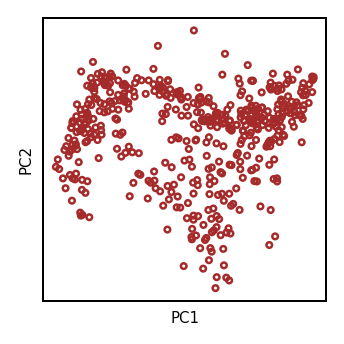

In [157]:
fig, ax = plt.subplots()
ax.scatter(Xpc[:, 0], Xpc[:, 1], s=5, fc='none', ec='brown')
ax.set_xticks([])
ax.set_xlabel('PC1')
ax.set_yticks([])
ax.set_ylabel('PC2')
set_plotsize(w=4, ax=ax)
fig.savefig('qc/figures/metrics_pca.svg')


In [113]:
session = _load_event_times(session, one=one_remote)

/home/crombie/code/ibl_neuromodulators/util.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series['cue_times'] = trials['goCue_times'].values
/home/crombie/code/ibl_neuromodulators/util.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series['cue_times'] = trials['goCue_times'].values
/home/crombie/code/ibl_neuromodulators/util.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series['movement_times'] = trials['firstMov

In [29]:
%matplotlib inline

events_colors = {'cue': 'black', 'movement': 'black', 'reward': 'black', 'omission':'gray'}

psths = []
y_max = 0
for event in events_colors.keys():
    responses, tpts = psth(F[session['ROI'][0]], session[f'{event}_times'])
    psths.append(responses)
    resp_max = np.abs(responses.mean(axis=0)).max()
    y_max = resp_max if resp_max > y_max else y_max
y_max += y_max / 10
y_max = 2e-6

# for responses, (event, color) in zip(psths, events_colors.items()):
for responses, event in zip(psths, events_colors.keys()):
    if not event == 'omission':
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(tpts, responses.mean(axis=0), color=colors[session['target_NM']], label=event)
    ax.plot(tpts, responses.mean(axis=0) - stats.sem(responses, axis=0), ls='--', color=colors[session['target_NM']])
    ax.plot(tpts, responses.mean(axis=0) + stats.sem(responses, axis=0), ls='--', color=colors[session['target_NM']])
    ax.axvline(0, ls='--', color='black', alpha=0.5)
    ax.axhline(0, ls='--', color='gray', alpha=0.5)
    ax.set_xlabel('Time (s)')
    # ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), frameon=False)
    if not event == 'omission':
        ax.set_title(event.capitalize())
    set_plotsize(1.5, ax=ax)
    if event == 'cue':
        ax.set_yticks([-1 * y_max, 0, y_max])
        # ax.set_yticklabels([f'{tick:.2e}' for tick in ax.get_yticks()])
        ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
        ax.set_ylabel('Response (a.u.)')
    else:
        ax.set_ylim([-1 * y_max, y_max])
        ax.set_yticks([])
    fig.savefig(f'qc/figures/arscore_bad_{event}.svg')

ValueError: need at least one array to stack

> /home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/shape_base.py(444)stack()
    442     arrays = [asanyarray(arr) for arr in arrays]
    443     if not arrays:
--> 444         raise ValueError('need at least one array to stack')
    445 
    446     shapes = {arr.shape for arr in arrays}



ipdb>  u


> /tmp/ipykernel_141462/3923110604.py(8)psth()
      6     i0s = inds - int(t0 // dt)
      7     i1s = inds + int(t1 // dt)
----> 8     responses = np.stack([F.values[i0:i1] for i0, i1 in zip(i0s, i1s)])
      9     tpts_resp = np.linspace(-1 * t0, t1, responses.shape[1])
     10     responses = (responses.T - responses[:, tpts_resp.searchsorted(0)]).T



ipdb>  t0


0.1


ipdb>  ts


array([], dtype=float64)


ipdb>  c


In [30]:
session

NM                                                                           5HT
ROI                                                                   [Region3G]
_deviance_p                                                             0.000001
_deviance_r                                                            -0.630668
_deviance_times                [10663.836064, 10723.800896, 10783.765664, 108...
_deviance_values               [0.007208846584536928, 0.004992387494251136, 0...
_expmax_violation_p                                                     0.101476
_expmax_violation_r                                                     0.229649
_expmax_violation_times        [10663.836064, 10723.800896, 10783.765664, 108...
_expmax_violation_values       [1.8280024726069141e-06, 0.0, 0.0, 0.0, 0.0, 0...
_n_expmax_violations_p                                                  0.175297
_n_expmax_violations_r                                                  0.190864
_n_expmax_violations_times  

#### Deviance

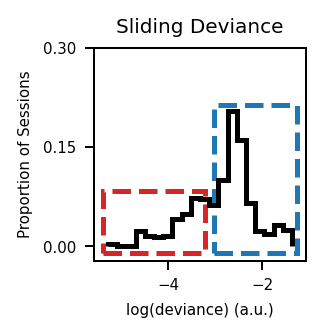

In [480]:
%matplotlib inline
fig, ax = plt.subplots()

data = df_targets['deviance']
data = np.log10(df_targets['deviance'][df_targets['deviance'] > 0])
weights = np.ones_like(data) / len(data)
counts, bins, _ = ax.hist(data, weights=weights, bins=20, histtype='step', linewidth=2, color='black')
good = Rectangle(
    (bins[12] - 0.1, -0.01), (bins[20] - bins[12] + 0.2), counts[12:20].max() + 0.02,
    fc='none', ec='tab:blue', ls='--', lw=2
)
ax.add_patch(good)
bad = Rectangle(
    (bins[0] - 0.1, -0.01), (bins[10] - bins[0] + 0.2), counts[:10].max() + 0.02,
    fc='none', ec='tab:red', ls='--', lw=2
)
ax.add_patch(bad)
# ax.set_xticklabels(['$10^{%.2f}$' % tick for tick in ax.get_xticks()])
ax.set_xlabel('log(deviance) (a.u.)')
ax.set_yticks([0, 0.15, 0.3])
ax.set_ylabel('Proportion of Sessions')
ax.set_title('Sliding Deviance', fontsize=8)
set_plotsize(w=3, ax=ax)
fig.savefig('qc/figures/deviance.svg')

In [488]:
# Bad values
cutoff = 10 ** bins[10]
df_metric = df_targets[df_targets['deviance'] < cutoff]
print(cutoff, len(df_metric))

0.00047346076945458304 186


In [489]:
session = df_metric.iloc[111].copy()
print(session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

biased


interleaved_acquisition        True
n_unique_samples               2028
f_unique_samples           0.011706
dt_violations                     0
deviance                   0.000413
n_spikes_dy                0.363636
expmax_violation           0.000001
percentile_dist            1.687129
signal_asymmetry           4.077381
ar_score                   0.000281
Name: 590, dtype: object

In [490]:
# Good values
cutoff = 10 ** bins[12]
df_metric = df_targets[df_targets['deviance'] > cutoff]
print(cutoff, len(df_metric))

0.001164859999255469 410


In [491]:
session = df_metric.iloc[12].copy()
print(session['session_type'])
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

training


interleaved_acquisition         True
n_unique_samples               15646
f_unique_samples            0.360889
dt_violations                    333
deviance                    0.031359
n_spikes_dy                10.333333
expmax_violation            0.000187
percentile_dist             1.980185
signal_asymmetry             1.64887
ar_score                    0.844004
Name: 22, dtype: object

In [492]:
try:
    photometry = load_photometry_data(session, one_remote, extracted=True)
except:
    photometry = load_photometry_data(session, one_local, extracted=False)

gcamp = photometry.query('name == "GCaMP"')
F = gcamp[session['ROI']]

pipeline = [
    (proc.remove_spikes, {'delta': 't'}),
    (proc.sliding_robust_zscore, {'w_len': 10})
]

F_proc = pipelines.run_pipeline(pipeline, F).dropna()

In [493]:
%matplotlib tk
fig, ax = plt.subplots()

t0, t1 = 4100, 4160
i0, i1 = F_proc.index.values.searchsorted([t0, t1])

ax.plot(F.iloc[i0:i1], color=colors[session['target_NM']], label='GCaMP raw')
# ax.plot(F, color=colors[session['target_NM']], label='GCaMP raw')
# ax.plot(F_proc.iloc[i0:i1], color=colors[session['target_NM']], label='GCaMP processed')
ax.set_xlabel('Time (s)')
ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
# ax.set_yticklabels(f'{tick:.2e}' for tick in ax.get_yticks())
ax.set_ylabel('Signal (a.u.)')
# ax.legend(loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title(f"{session['target_NM']} - {session['session_type']} session - GCaMP raw", fontsize=8)
set_plotsize(w=5, h=2, ax=ax)
fig.savefig('qc/figures/deviance_good_signal.svg')

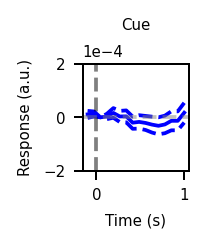

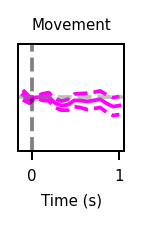

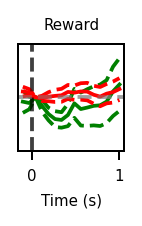

In [503]:
%matplotlib inline

session = _load_event_times(session, one_remote)
events_colors = {'cue': 'blue', 'movement': 'magenta', 'reward': 'green', 'omission':'red'}

psths = []
y_max = 0
for event in events_colors.keys():
    responses, tpts = psth(F[session['ROI'][0]], session[f'{event}_times'])
    psths.append(responses)
    resp_max = np.abs(responses.mean(axis=0)).max()
    y_max = resp_max if resp_max > y_max else y_max
y_max += y_max / 10
y_max = 2e-4

for responses, (event, color) in zip(psths, events_colors.items()):
    if not event == 'omission':
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(tpts, responses.mean(axis=0), color=color, label=event)
    ax.plot(tpts, responses.mean(axis=0) - stats.sem(responses, axis=0), ls='--', color=color)
    ax.plot(tpts, responses.mean(axis=0) + stats.sem(responses, axis=0), ls='--', color=color)
    ax.axvline(0, ls='--', color='black', alpha=0.5)
    ax.axhline(0, ls='--', color='gray', alpha=0.5)
    ax.set_xlabel('Time (s)')
    # ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), frameon=False)
    if not event == 'omission':
        ax.set_title(event.capitalize())
    set_plotsize(1.5, ax=ax)
    if event == 'cue':
        ax.set_yticks([-1 * y_max, 0, y_max])
        # ax.set_yticklabels([f'{tick:.2e}' for tick in ax.get_yticks()])
        ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
        ax.set_ylabel('Response (a.u.)')
    else:
        ax.set_ylim([-1 * y_max, y_max])
        ax.set_yticks([])
    fig.savefig(f'qc/figures/deviance_good_{event}.svg')

### Interleaved acquisition

In [504]:
df = df_targets[~df_targets['interleaved_acquisition'] & (df_targets['dt_violations'] % 2 == 0)]
print(len(df))

58


In [505]:
session = df.iloc[5]
photometry = load_photometry_data(session, one_local, extracted=False)
session[csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

interleaved_acquisition       False
n_unique_samples               9608
f_unique_samples           0.204356
dt_violations                   472
deviance                    0.00162
n_spikes_dy                0.444444
expmax_violation           0.000011
percentile_dist            1.728901
signal_asymmetry           2.527751
ar_score                   0.122949
Name: 210, dtype: object

In [506]:
%matplotlib tk
fig, ax = plt.subplots(figsize=(6, 4))

gcamp = photometry.query('name == "GCaMP"')
iso = photometry.query('name == "Isosbestic"')
ax.plot(iso[session['ROI'][0]], marker='o', color='gray', label='Isosbestic')
ax.plot(gcamp[session['ROI'][0]], marker='o', color=colors[session['target_NM']], label='GCaMp')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal (a.u.)')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)


In [208]:
df = df_targets[df_targets['n_unique_samples'] < 1000]
print(len(df))

144


In [216]:
session = df.iloc[2]
photometry = load_photometry_data(session, one_local, extracted=False)
session[['eid'] + csv_metrics + raw_metrics + sliding_metrics + processed_metrics]

eid                        4ea40125-7240-47e6-ac35-bb59dc8ad86f
interleaved_acquisition                                    True
n_unique_samples                                            358
f_unique_samples                                       0.005279
dt_violations                                               744
deviance                                                    0.0
n_spikes_dy                                                 298
expmax_violation                                       0.000005
percentile_dist                                        3.083899
signal_asymmetry                                            inf
low_freq_power_ratio                                    0.43567
ar_score                                              -0.000184
Name: 113, dtype: object

In [218]:
%matplotlib tk
fig, ax = plt.subplots(figsize=(6, 4))

gcamp = photometry.query('name == "GCaMP"')
iso = photometry.query('name == "Isosbestic"')
ax.plot(gcamp[session['ROI'][0]], color=colors[session['target_NM']], label='GCaMP')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal (a.u.)')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)


In [242]:
df_targets['expmax_violation'] > 

(array([528.,  18.,  11.,   2.,   1.,   1.,   1.,   1.,   0.,   4.]),
 array([0.        , 0.00011693, 0.00023385, 0.00035078, 0.0004677 ,
        0.00058463, 0.00070155, 0.00081848, 0.0009354 , 0.00105233,
        0.00116925]),
 <BarContainer object of 10 artists>)

In [20]:
pipeline = [
    (proc.remove_spikes, {'delta': 't'}),
    (proc.sliding_robust_zscore, {'w_len': 5})
]

In [25]:
session = df.iloc[215]
photometry = load_photometry_data(session, one_local, extracted=False)
session[csv_metrics + raw_metrics + processed_metrics]

dt_violations                     0
interleaved_acquisition        True
n_unique_samples              11193
f_unique_samples           0.113472
n_spikes_dy                       1
n_outliers                       25
expmax_violation           0.000189
deviance                   0.032317
percentile_dist            2.192259
low_freq_power_ratio       0.998687
ar_score                   0.997834
Name: 738, dtype: object

In [54]:
from util import _load_event_times

In [55]:
df_qc.apply(_load_event_times, one=one, axis='columns')

,NM,_ar_score_p,_ar_score_r,_ar_score_times,_ar_score_values,_deviance_p,_deviance_r,_deviance_times,_deviance_values,_expmax_violation_p,...,omission_times,percentile_dist,reward_times,roi,session_type,signal_asymmetry,start_time,strain,subject,targeted_regions
0,5HT,2.176503e-08,-0.526494,"[1550.923776, 1580.989376, 1611.321632, 1641.5...","[0.901345159747499, 0.9464004901722167, 0.9305...",1.165786e-05,-0.424925,"[1550.923776, 1580.989376, 1611.321632, 1641.5...","[0.01443873807776788, 0.007074552594503888, 0....",2.351264e-02,...,"[29.9421, 37.605000000000004, 73.5354999999999...",1.003948,"[14.071900000000001, 24.877200000000002, 48.01...",Region4G,training,0.368425,2021-08-27T10:14:49.383803,Ai148xSERTCre,ZFM-03062,[MR]
1,5HT,5.769312e-02,-0.191422,"[1550.923776, 1580.989376, 1611.321632, 1641.5...","[0.8600880109684149, 0.8794683496929634, 0.881...",9.637370e-10,-0.566766,"[1550.923776, 1580.989376, 1611.321632, 1641.5...","[0.03385050292551421, 0.03301896291323814, 0.0...",1.332652e-03,...,"[18.6195, 49.6135, 59.996899, 73.4806000000000...",1.808537,"[8.909600000000001, 11.6724, 135.7933000000000...",Region1G,training,1.699016,2021-08-27T10:18:12.784055,Ai148xSERTCre,ZFM-03065,[DR]
2,5HT,1.836522e-02,-0.241547,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.791876175048804, 0.9366743300464845, 0.8843...",8.324779e-04,-0.337221,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.007340395732002399, 0.008169532373635201, 0...",8.206175e-02,...,"[25.950298999999998, 36.1976, 44.3807, 59.8447...",1.984716,"[14.3543, 19.943799999999996, 64.1746, 83.0249...",Region1G,training,1.828710,2021-08-27T11:18:32.529960,Ai148xSERTCre,ZFM-03059,[DR]
3,5HT,8.851599e-14,-0.672107,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[-0.08605383761468866, -0.5172052236638258, -0...",9.168165e-02,-0.174022,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.00035127434526441417, 0.0003513291954569089...",3.755670e-02,...,NaN,2.010618,NaN,Region4G,habituation,222.888406,2021-08-27T11:23:53.754095,Ai148xSERTCre,ZFM-03061,"[DR, MR]"
4,5HT,1.682220e-17,-0.736970,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.013373687410070056, -0.3908831440827607, -0...",5.612556e-08,-0.522467,"[5385.39088, 5415.38992, 5445.388896, 5475.387...","[0.0005491703604989111, 0.0004709576138320842,...",2.771763e-01,...,NaN,2.210126,NaN,Region6G,habituation,149.434109,2021-08-27T11:23:53.754095,Ai148xSERTCre,ZFM-03061,"[DR, MR]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,none,2.147075e-29,-0.874505,"[57.912820281528184, 87.877898492236, 117.8429...","[0.958789597054216, 0.9156390309867528, 0.9041...",1.105848e-11,-0.640055,"[57.912820281528184, 87.877898492236, 117.8429...","[0.005530027252296051, 0.003794533061623815, 0...",5.090685e-02,...,"[32.699799999999996, 53.502599999999994, 61.93...",2.194243,"[39.7378, 44.521499999999996, 48.5629, 66.0497...",G4,training,2.152759,2024-11-05T15:28:52.921000,B6.Cg,CQ002,[]
979,none,6.398447e-02,-0.198324,"[278.49746608083626, 308.46262089412596, 338.4...","[-0.4237746203043762, -0.4167997408659607, -0....",2.544897e-04,-0.380573,"[278.49746608083626, 308.46262089412596, 338.4...","[0.0003285798777726404, 0.0003286338690108921,...",4.556092e-01,...,"[256.927699, 271.53969900000004, 284.404399000...",1.741417,"[251.32769899999997, 261.943299, 268.223799000...",G0,training,1.292453,2024-11-07T15:15:38.587000,B6.Cg,CQ001,[]
980,none,1.016015e-17,-0.759236,"[278.49746608083626, 308.46262089412596, 338.4...","[0.9495966730337208, 0.915892129121367, 0.8909...",2.391103e-28,-0.871500,"[278.49746608083626, 308.46262089412596, 338.4...","[0.008317025440310113, 0.005148342059341304, 0...",3.980689e-08,...,"[256.927699, 271.53969900000004, 284.404399000...",2.579287,"[251.32769899999997, 261.943299, 268.223799000...",G4,training,5.146939,2024-11-07T15:15:38.587000,B6.Cg,CQ001,[]
981,none,2.063082e-28,-0.881214,"[219.5858441220089, 249.55089014542773, 279.51...","[

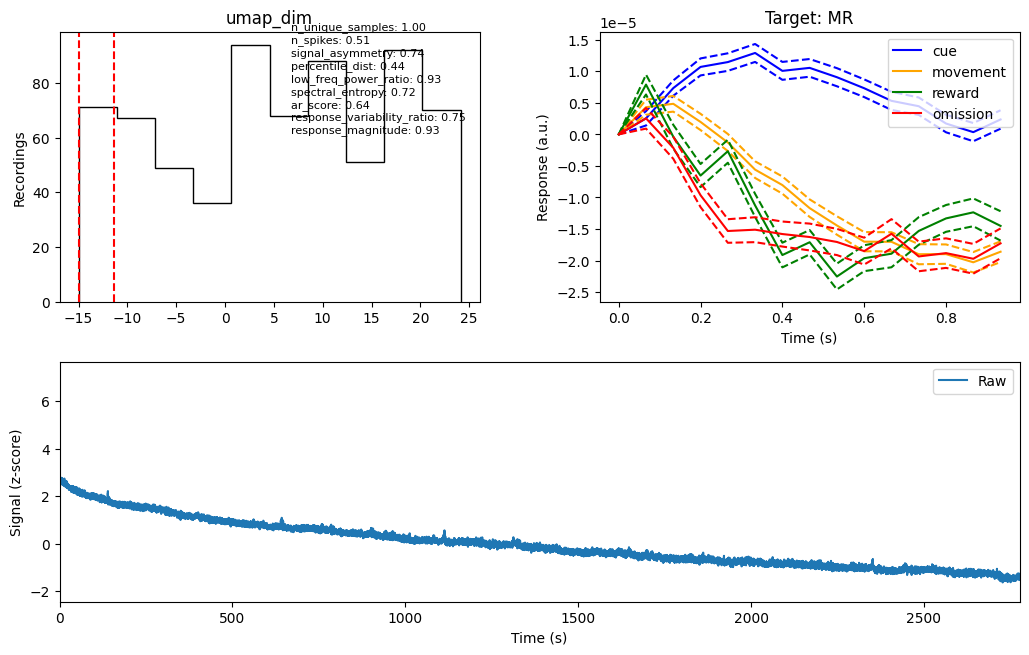

In [332]:
# Pick an event
metric = 'umap_dim'
fig, ax = plot_qc_example(df_metrics, metric, percentile_range=[0, 10]) 

In [237]:
df_metrics = df_metrics.dropna(subset=metrics_dict.keys())

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


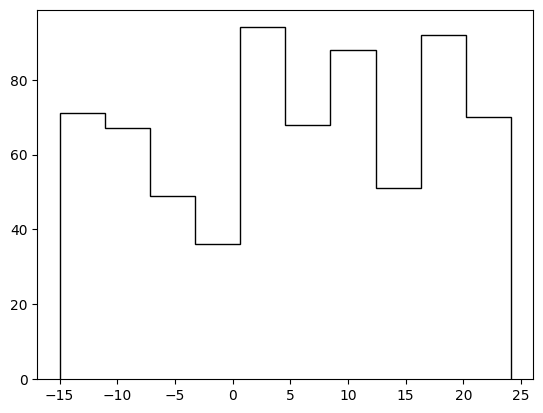

In [322]:
metrics_list = [
    'n_unique_samples',
    # 'n_spikes',
    'signal_asymmetry',
    'percentile_dist',
    'low_freq_power_ratio',
    # 'spectral_entropy',
    'ar_score',
    # 'response_variability_ratio',
    # 'response_magnitude'
    ]

X = df_metrics[metrics_list].values
X = quantile_transform(X, output_distribution='normal', n_quantiles=100)

n_components = 1  # 1, 2
dist = 'euclidean'  # 'euclidean', 'cosine'

umap = UMAP(n_components=n_components, metric=dist)
X_prime = umap.fit_transform(X)

fig, ax = plt.subplots()
if n_components == 2:
    ax.scatter(X_prime[:, 0], X_prime[:, 1], fc='none', ec='black')
elif n_components == 1:
    ax.hist(X_prime, histtype='step', color='black')

df_metrics = df_metrics.assign(umap_dim=X_prime[:, 0])

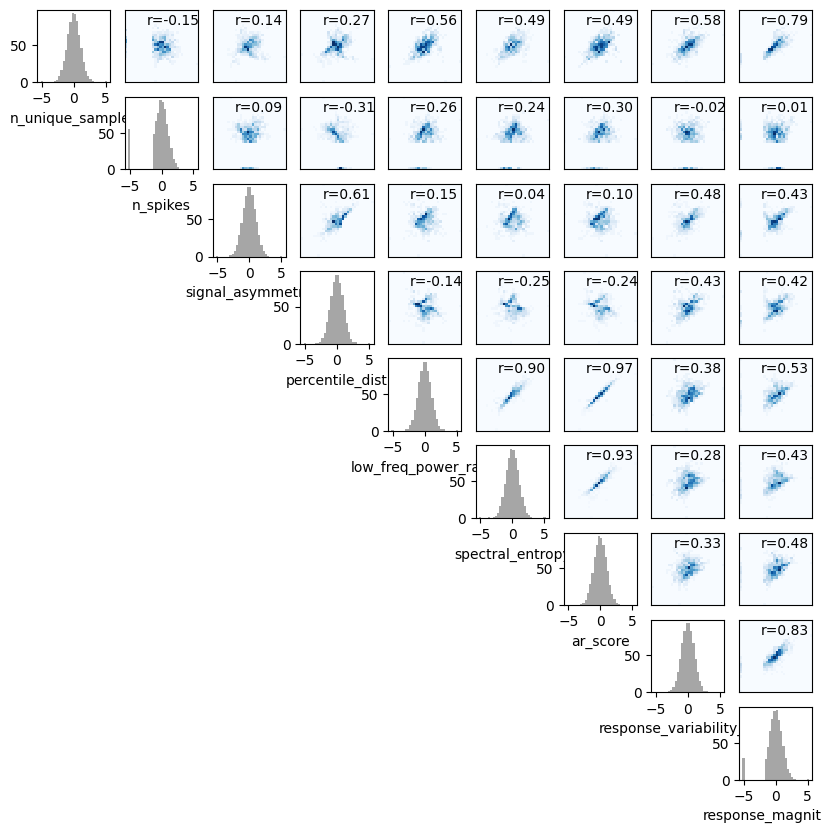

,n_unique_samples,n_spikes,signal_asymmetry,percentile_dist,low_freq_power_ratio,spectral_entropy,ar_score,response_variability_ratio,response_magnitude
n_unique_samples,1.000000,-0.154467,0.138944,0.269289,0.556194,0.492490,0.489630,0.583728,0.794997
n_spikes,-0.154467,1.000000,0.088316,-0.311249,0.258841,0.238464,0.304242,-0.021240,0.009376
signal_asymmetry,0.138944,0.088316,1.000000,0.612764,0.150337,0.035894,0.098678,0.476866,0.431781
percentile_dist,0.269289,-0.311249,0.612764,1.000000,-0.143797,-0.250659,-0.239635,0.431901,0.415428
low_freq_power_ratio,0.556194,0.258841,0.150337,-0.143797,1.000000,0.902190,0.966302,0.384851,0.530546
spectral_entropy,0.492490,0.238464,0.035894,-0.250659,0.902190,1.000000,0.929756,0.283641,0.430927
ar_score,0.489630,0.304242,0.098678,-0.239635,0.966302,0.929756,1.000000,0.325709,0.475713
response_variability_ratio,0.583728,-0.021240,0.476866,0.431901,0.384851,0.283641,0.325709,1.000000,0.825666
response_magnitude,0.794997,0.009376,0.431781,0.415428,0.530546,0.430927,0.475713,0.825666,1.000000


In [364]:
from copulas.multivariate import GaussianMultivariate 

In [366]:
cop = GaussianMultivariate()

In [369]:
cop.fit(df_metrics[metrics_dict.keys()].dropna().values)

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6720: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWa

In [378]:
cop.sample?

Signature: cop.sample(num_rows=1, conditions=None)
Docstring:
Sample values from this model.

Argument:
    num_rows (int):
        Number of rows to sample.
    conditions (dict or pd.Series):
        Mapping of the column names and column values to condition on.

Returns:
    numpy.ndarray:
        Array of shape (n_samples, *) with values randomly
        sampled from this model distribution. If conditions have been
        given, the output array also contains the corresponding columns
        populated with the given values.

Raises:
    NotFittedError:
        if the model is not fitted.
File:      ~/miniconda3/envs/iblenv/lib/python3.10/site-packages/copulas/multivariate/gaussian.py
Type:      method

In [550]:
df_metrics['target'] = df_metrics['targeted_regions'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [551]:
df_metrics['target'].unique()

array(['DR', 'MR', 'VTA', 'SNc', 'LC', nan, 'NBM'], dtype=object)

In [401]:
df_metrics = df_metrics.sort_values(['subject', 'date'])

In [402]:
# Convert date column to datetime and compute 'recording_day'
df_metrics['date'] = pd.to_datetime(df_metrics['date'])  # Ensure 'date' column is datetime

def _get_recording_days(group):
    group = group.copy()  # avoid SettingWithCopyWarning
    # group['recording_day'] = (group['date'] - group['date'].iloc[0])
    group['recording_day'] = np.arange(len(group))
    return group

df_metrics = df_metrics.groupby('subject', group_keys=False).apply(_get_recording_days)
# df_metrics['recording_day'] = df_metrics['recording_day'].apply(lambda x: x.days)

/tmp/ipykernel_51833/315210523.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics = df_metrics.groupby('subject', group_keys=False).apply(_get_recording_days)


In [403]:
# Max days to look into the future
day_max = 21

# Initialize lists to hold results
index = []
data = {'rsquared': [], 'pvalue': [], 'slope': []}

# Loop over metrics
for metric in metrics_dict.keys():
    # Loop over days offset
    for day in range(1, day_max):
        # Filter the data to get values at day 0 and day
        df_day0 = df_metrics[df_metrics['recording_day'] == 0]
        df_day = df_metrics[df_metrics['recording_day'] == day]
        # Merge the data, ensuring paired samples for each subject
        merged = pd.merge(df_day0[['subject', metric]], df_day[['subject', metric]], on='subject', suffixes=('_0', f'_{day}'))
        # Linear regression
        if len(merged) < 3:
            continue
        res = stats.linregress(merged[f'{metric}_0'], merged[f'{metric}_{day}'])
        # Append results
        index.append((metric, day))
        data['rsquared'].append(res.rvalue ** 2)
        data['pvalue'].append(res.pvalue)
        data['slope'].append(res.slope)

# Create the DataFrame
multi_index = pd.MultiIndex.from_tuples(index, names=["metric", "day"])
df_pred = pd.DataFrame(data, index=multi_index)

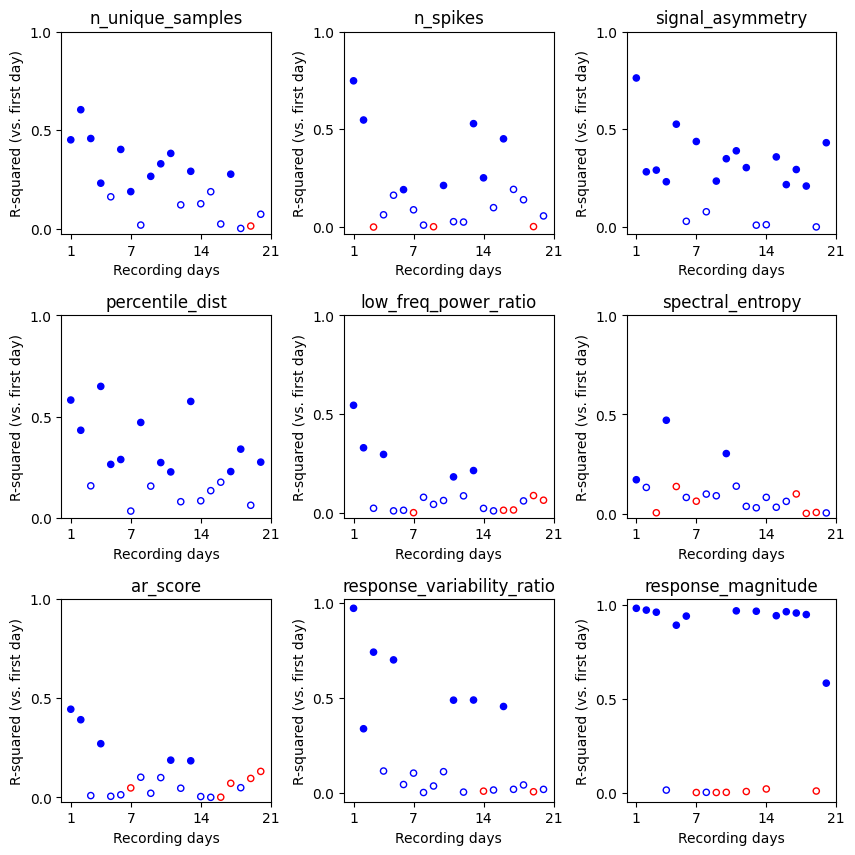

In [404]:
n_metrics = len(metrics_dict.keys())
fig, axs = plt.subplots(int(np.ceil(n_metrics / 3)), 3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.35)

for ax, (metric, values) in zip(axs.ravel(), df_pred.groupby('metric', sort=False)):
    values = values.droplevel('metric').reset_index('day')
    ec = ['blue' if s > 0 else 'red' for s in values['slope']]
    fc = [c if p <= 0.05 else 'none' for c, p in zip(ec, values['pvalue'])]
    ax.scatter(values['day'], values['rsquared'], s=20, ec=ec, fc=fc)
    ax.set_title(metric)
    ax.set_xticks([1, 7, 14, 21])
    ax.set_xlabel('Recording days')
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylabel('R-squared (vs. first day)')